In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
import pickle
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
target = 'Coeff_B'

# Standard Scaling

In [6]:
df_test = pd.read_csv('scaled_standard_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_standard_'+target+'_train.csv', encoding='cp1252')  

In [7]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [8]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [9]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [10]:
with open("standard_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [11]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)

# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.8964248843030014
RMSE:  0.3328645305474901
RMSE unscaled:  1.8651968188405853e-05
----------------------------------------


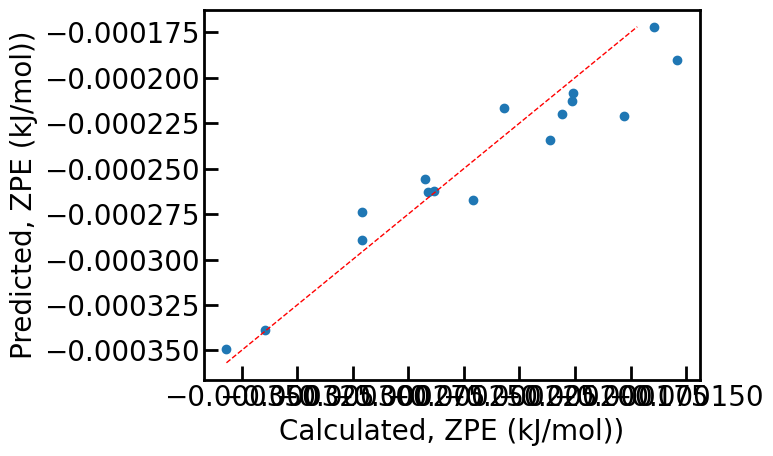

GB 0.8865861422788387
RMSE:  0.34831555373314926
RMSE unscaled:  1.951776182662625e-05
----------------------------------------


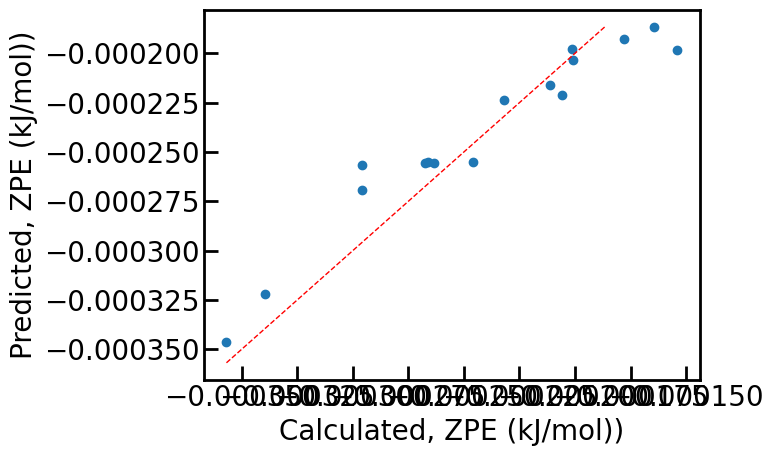

RR 0.667212217321947
RMSE:  0.5966552872410145
RMSE unscaled:  3.343340733468688e-05
----------------------------------------


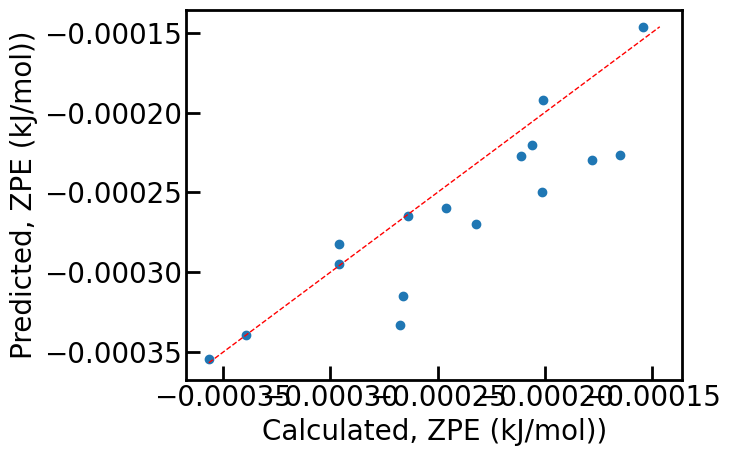

LASSO 0.9186879715692396
RMSE:  0.2949288137596037
RMSE unscaled:  1.652625121409134e-05
----------------------------------------


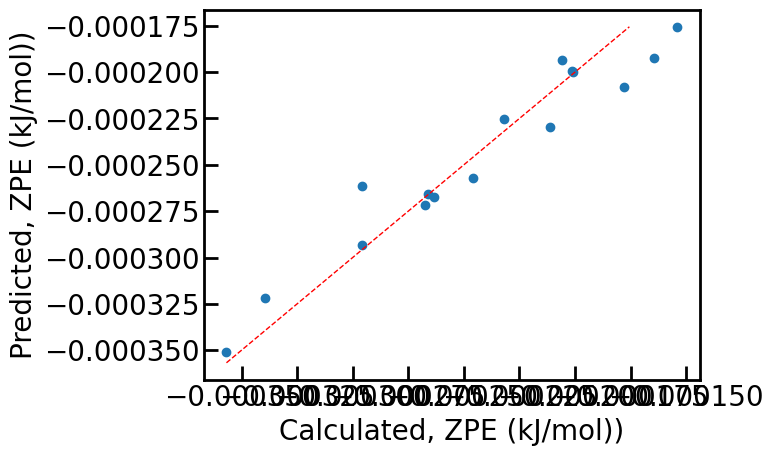

gpr1 0.9333606394571263
RMSE:  0.2669962839719357
RMSE unscaled:  1.4961059944945435e-05
----------------------------------------


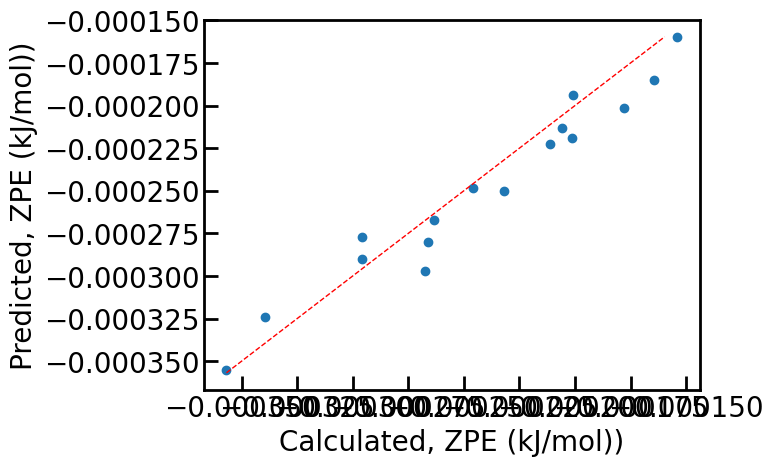

gpr2 0.9430155404652465
RMSE:  0.24689825655777295
RMSE unscaled:  1.38348727619431e-05
----------------------------------------


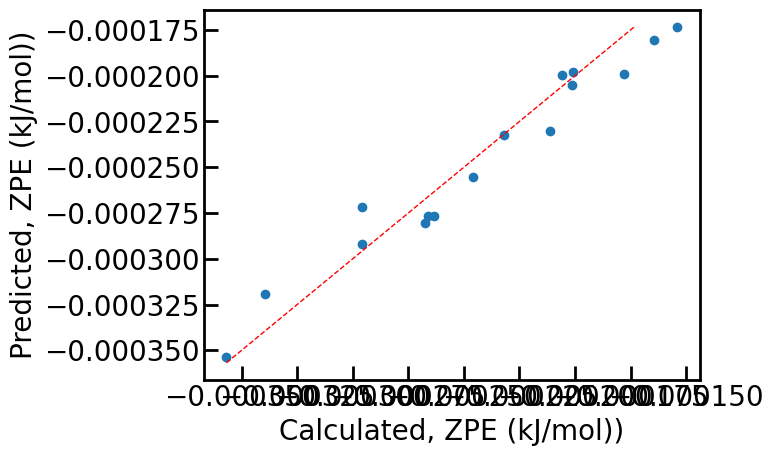

gpr3 0.9567449064040187
RMSE:  0.21510892726271805
RMSE unscaled:  1.205356684218387e-05
----------------------------------------


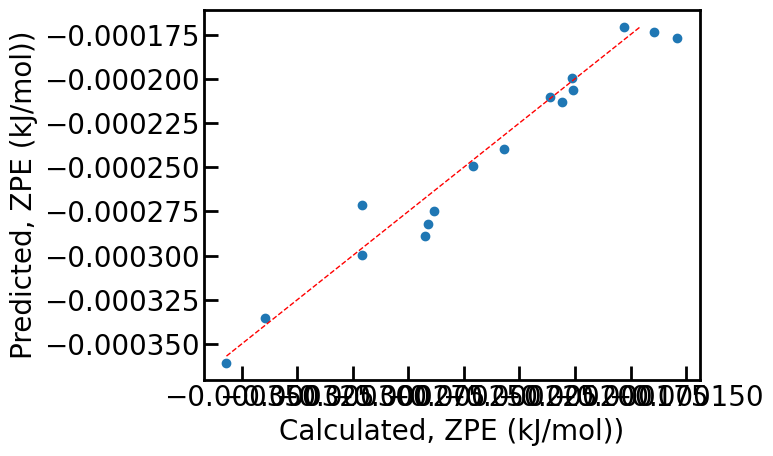

gpr4 0.973054374280125
RMSE:  0.16977898893627558
RMSE unscaled:  9.513516791622598e-06
----------------------------------------


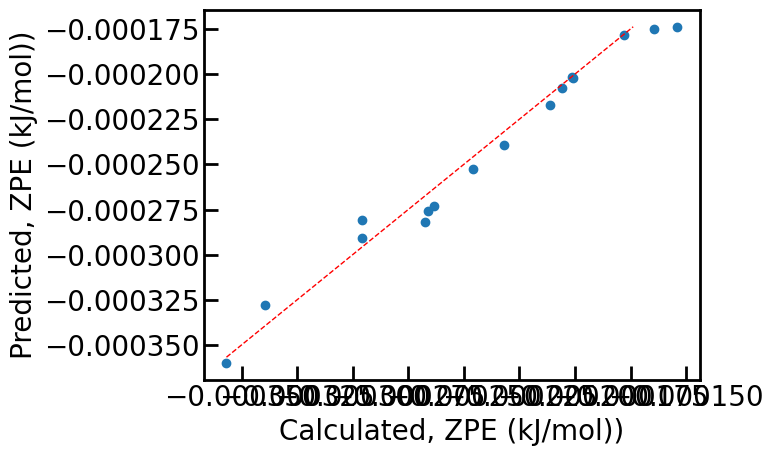

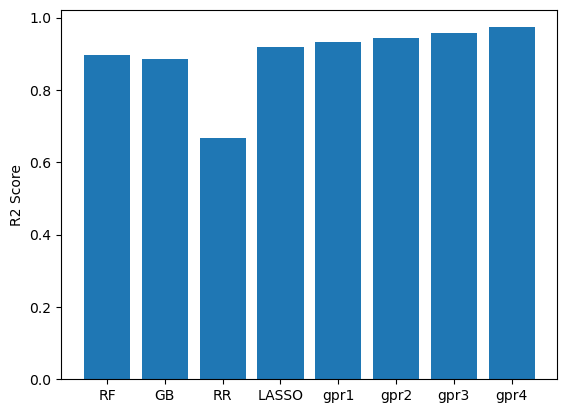

In [12]:
run_models()

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
26      X_EA  107.076012
1   mean_A2B   99.929262
14       X_Z   79.740038
34    X_Rvdw   72.806569
23    X_IEII   72.465869
4   mean_X2X   53.239994
32    A_Rvdw   39.367219
2   mean_A2X   37.109735
18     A_IEI   26.852117
9      E_coh   26.552367
30    A_ChiA   26.091491
44      B_Hf   13.952951
17       X_G   13.049317
24      A_EA   12.978514
6    std_A2X   12.535370
27    A_ChiP   12.150673
38      B_MP   11.671236
7    std_B2X   10.854134
11        OF    8.715184
37      A_MP    8.689131
13       B_Z    8.230539
47   X_Kappa    8.186239
45   A_Kappa    7.476652
46   B_Kappa    7.450582
36      B_Ra    7.059603
12       A_Z    6.801723
40     B_Rho    5.185659
43      X_MV    4.828899
48     A_CvM    4.781525
15       A_G    4.227267


In [14]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'A_MP',
       'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra', 'A_Z', 'B_Rho',
       'X_MV', 'A_CvM', 'A_G', 'B_EA', 'B_CvM', 'TF', 'std_X2X', 'A_B',
       'std_A2B', 'B_ChiP', 'X_IEI', 'B_MV', 'B_IEI'], dtype=object)

In [15]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9047332654562126
RMSE:  0.3192349602587181
RMSE unscaled:  1.7888239139144636e-05
----------------------------------------


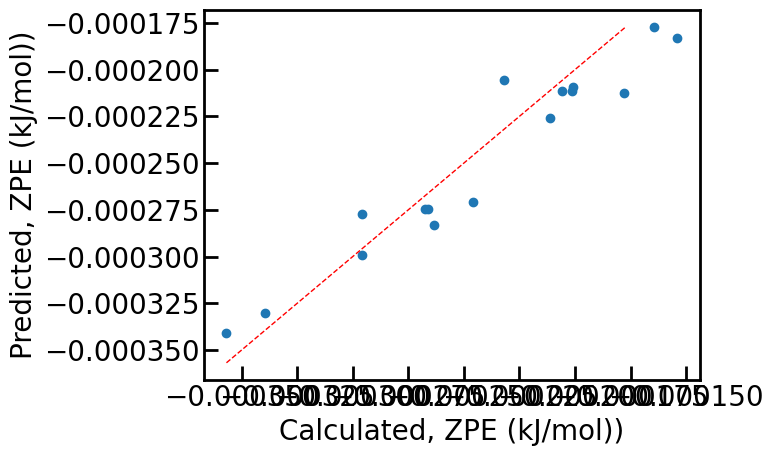

GB 0.8782800452439999
RMSE:  0.3608450046725162
RMSE unscaled:  2.0219846004699774e-05
----------------------------------------


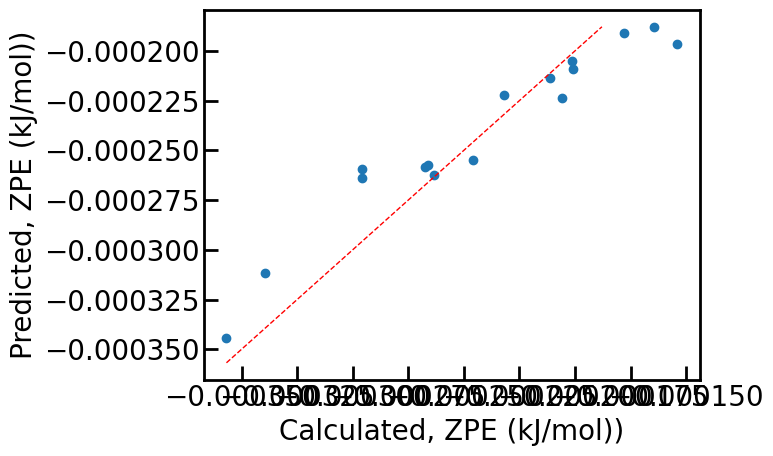

RR 0.880287015155595
RMSE:  0.3578577574878312
RMSE unscaled:  2.0052456468277843e-05
----------------------------------------


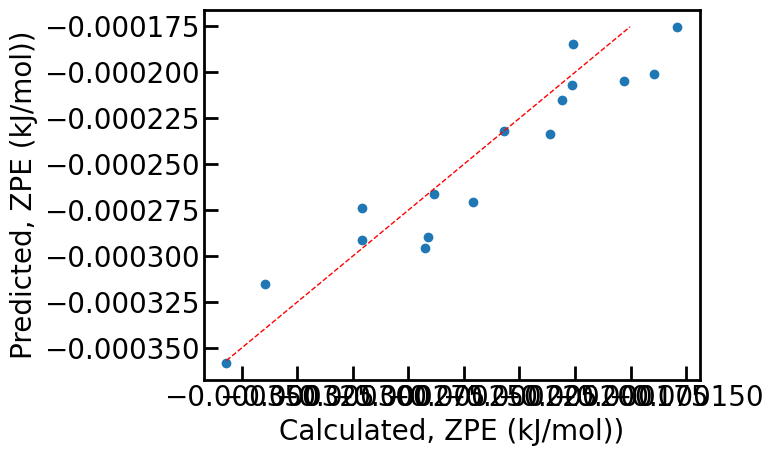

LASSO 0.9179434027489
RMSE:  0.29627605836760246
RMSE unscaled:  1.660174367803475e-05
----------------------------------------


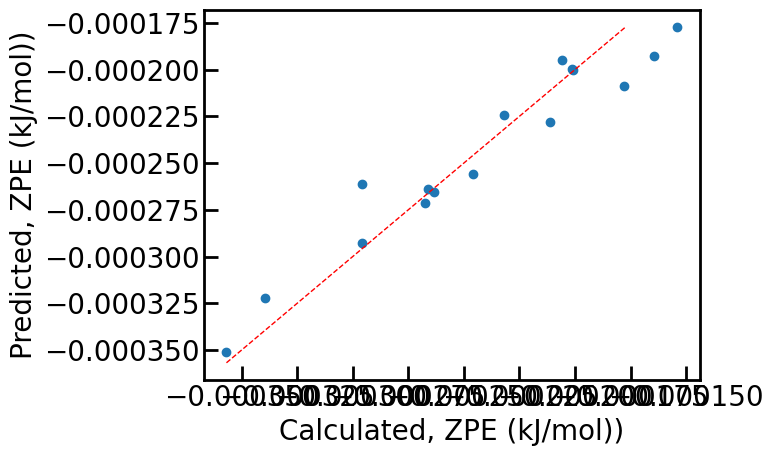

gpr1 0.9144251234711671
RMSE:  0.30256100008749387
RMSE unscaled:  1.6953918578834747e-05
----------------------------------------


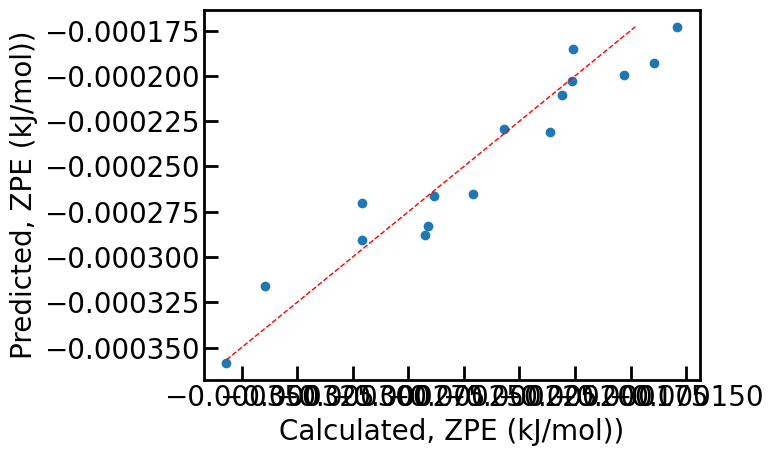

gpr2 0.9391295100956795
RMSE:  0.2551779857357003
RMSE unscaled:  1.4298825003959714e-05
----------------------------------------


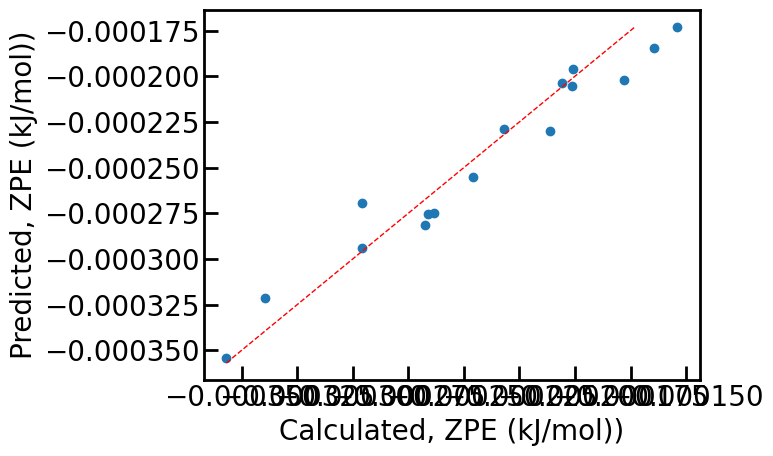

gpr3 0.9421485747662153
RMSE:  0.24876933074591115
RMSE unscaled:  1.3939717865679142e-05
----------------------------------------


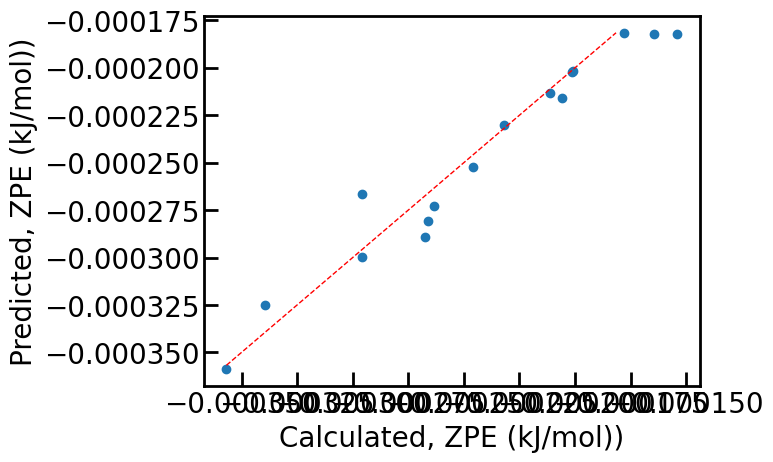

gpr4 0.9612035137129036
RMSE:  0.20372109580854303
RMSE unscaled:  1.1415452983465311e-05
----------------------------------------


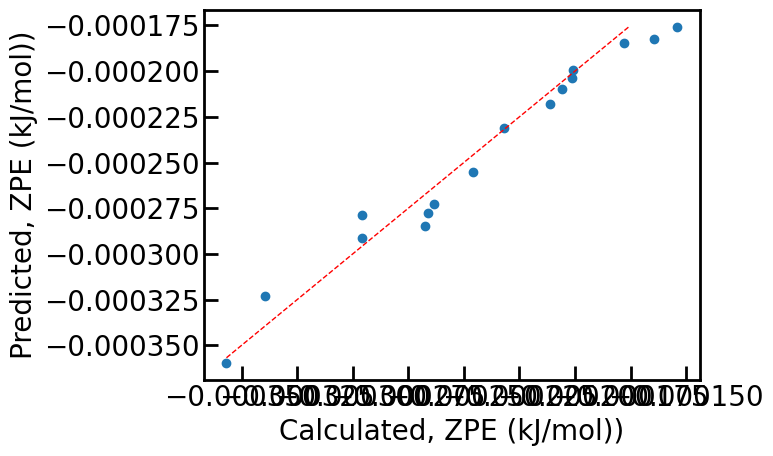

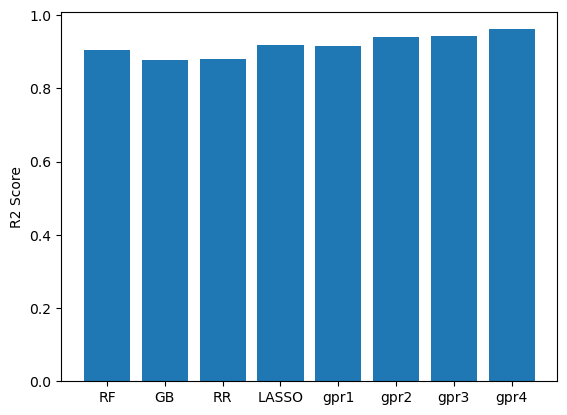

In [16]:
run_models()

In [17]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'A_MP',
       'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra', 'A_Z', 'B_Rho',
       'X_MV', 'A_CvM', 'A_G'], dtype=object)

In [18]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9073259424884172
RMSE:  0.3148610181111476
RMSE unscaled:  1.764314654949494e-05
----------------------------------------


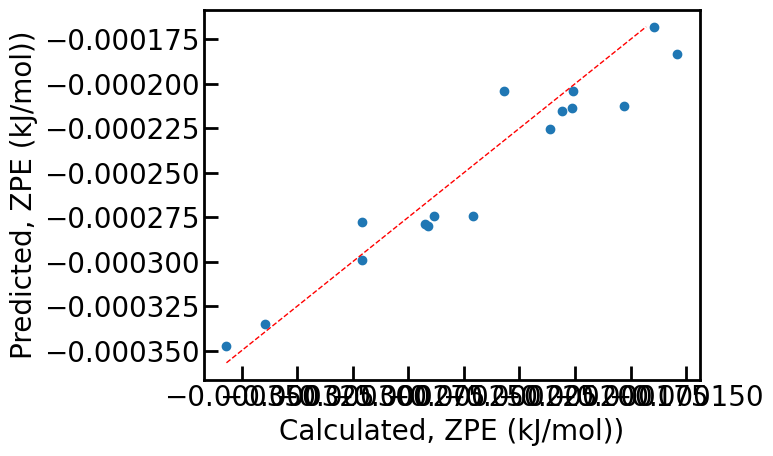

GB 0.8388727169431445
RMSE:  0.41516845554898624
RMSE unscaled:  2.3263844943144156e-05
----------------------------------------


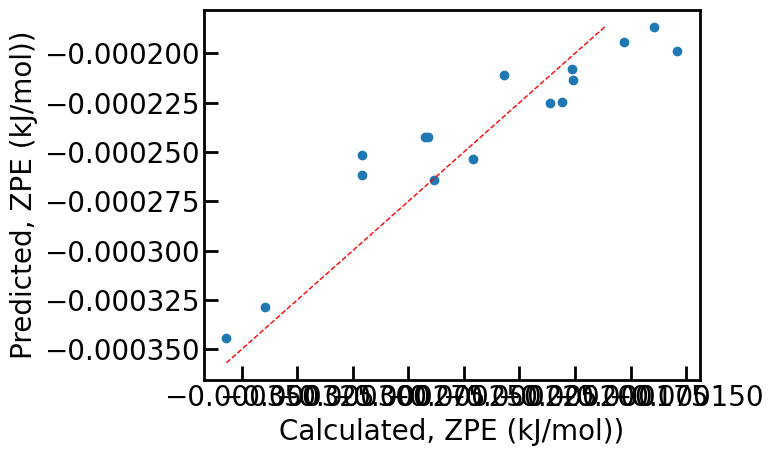

RR 0.9155208685353922
RMSE:  0.3006176853265152
RMSE unscaled:  1.68450254953866e-05
----------------------------------------


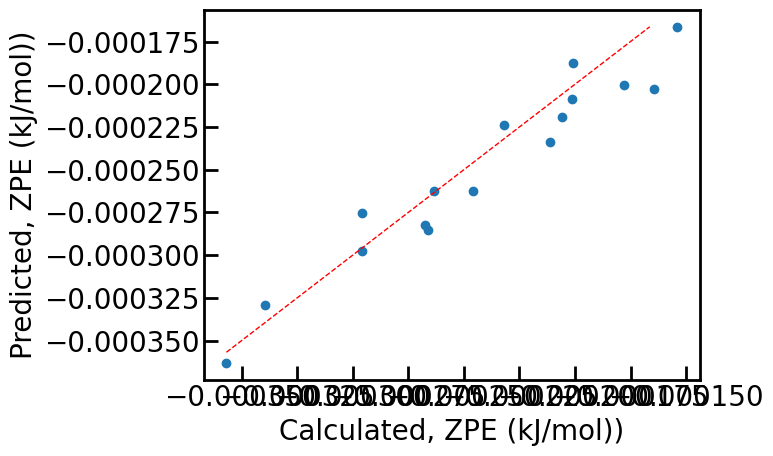

LASSO 0.9363233221488768
RMSE:  0.260993688467273
RMSE unscaled:  1.462470623307146e-05
----------------------------------------


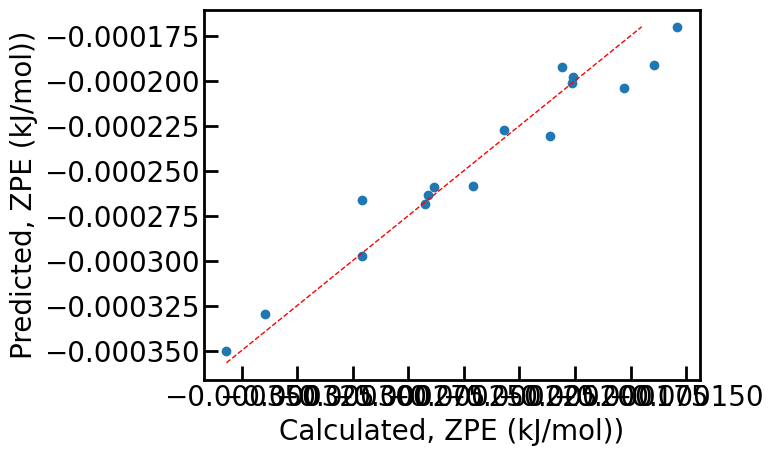

gpr1 0.9282343985804143
RMSE:  0.27707540122435564
RMSE unscaled:  1.5525840379947442e-05
----------------------------------------


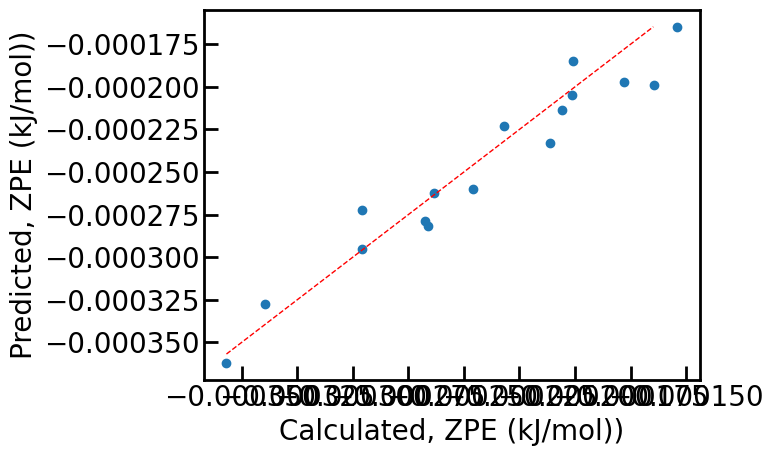

gpr2 0.9516903469293786
RMSE:  0.22733000723763847
RMSE unscaled:  1.2738371541997505e-05
----------------------------------------


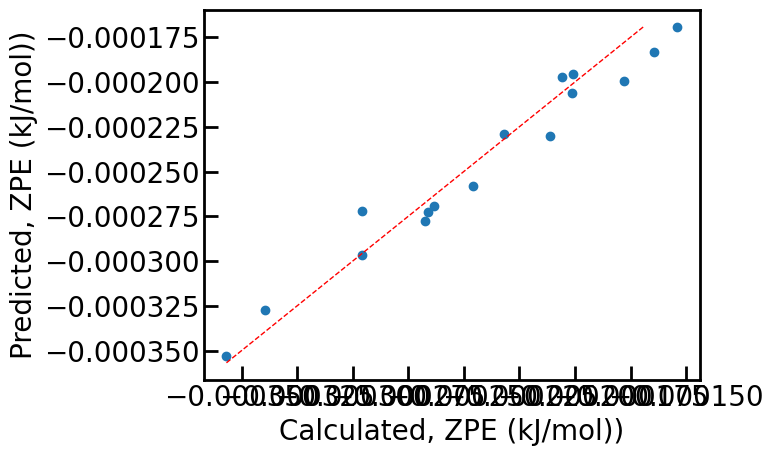

gpr3 0.9226206094527184
RMSE:  0.2877083450175094
RMSE unscaled:  1.6121654325797443e-05
----------------------------------------


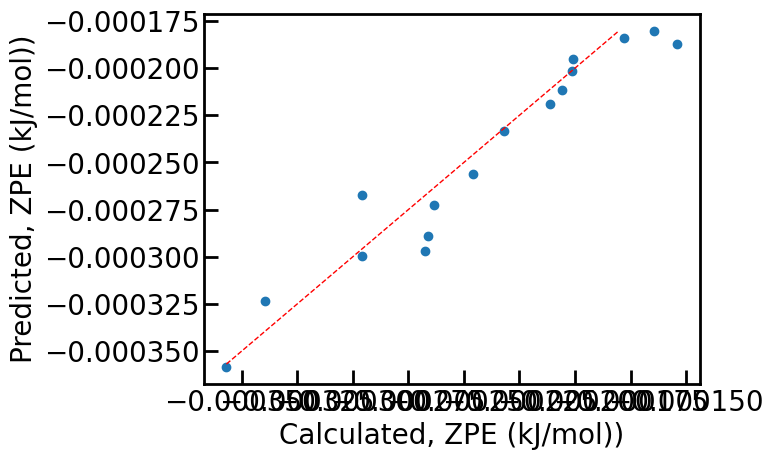

gpr4 0.9498541086566267
RMSE:  0.23161009466541876
RMSE unscaled:  1.2978205009430176e-05
----------------------------------------


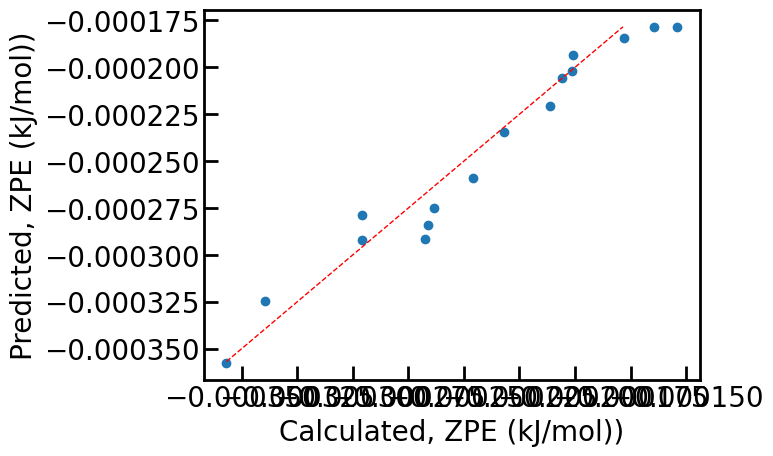

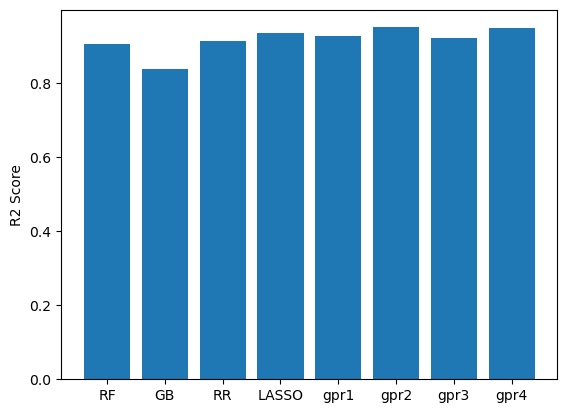

In [19]:
run_models()

In [20]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'std_B2X', 'OF', 'A_MP'],
      dtype=object)

In [21]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8850542255951747
RMSE:  0.35066006719245096
RMSE unscaled:  1.964913596369114e-05
----------------------------------------


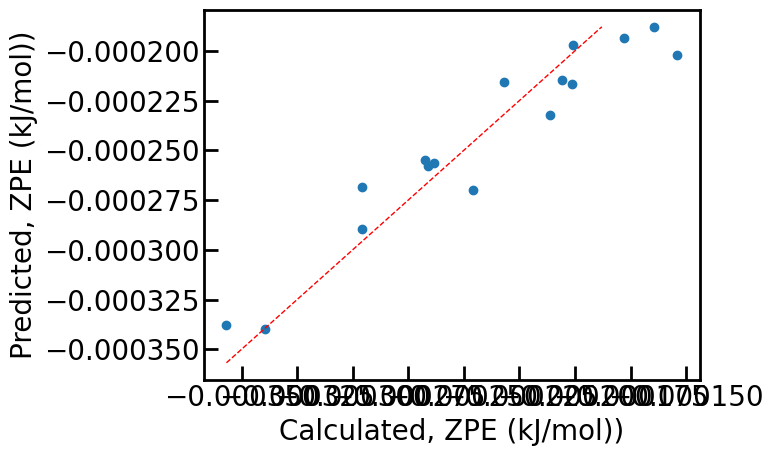

GB 0.8602863965689409
RMSE:  0.3865975998157611
RMSE unscaled:  2.1662885263315426e-05
----------------------------------------


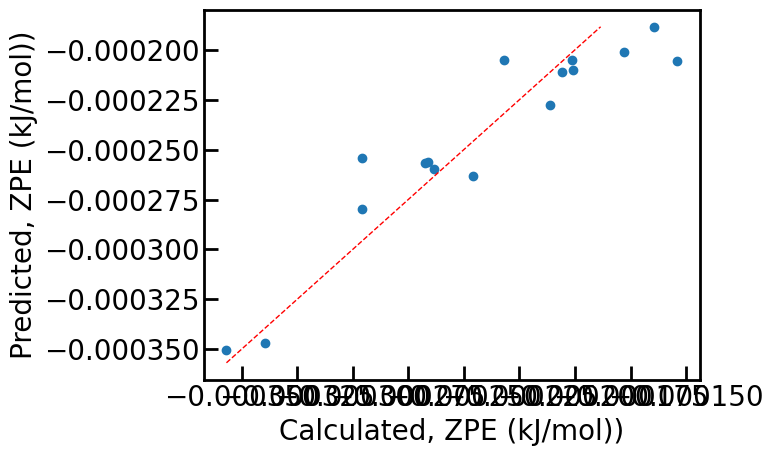

RR 0.9137623073031405
RMSE:  0.3037304759000451
RMSE unscaled:  1.7019449819477708e-05
----------------------------------------


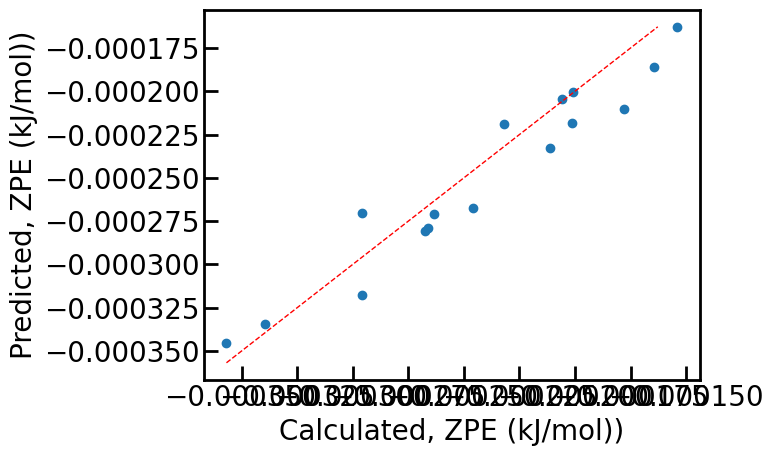

LASSO 0.9084749900088642
RMSE:  0.31290297974410747
RMSE unscaled:  1.7533428433017826e-05
----------------------------------------


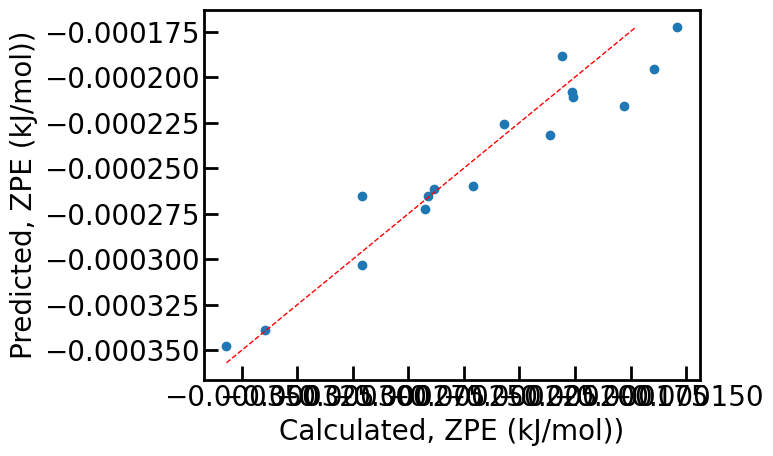

gpr1 0.9214442857782688
RMSE:  0.2898869715449318
RMSE unscaled:  1.624373303636797e-05
----------------------------------------


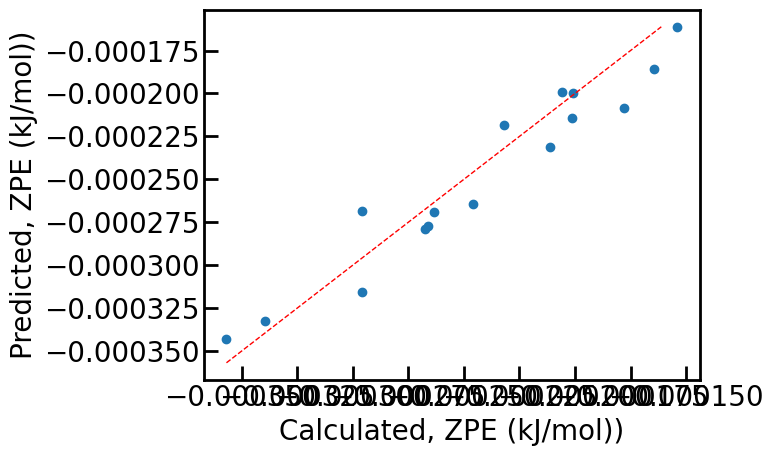

gpr2 0.9210546912321798
RMSE:  0.2906049250496654
RMSE unscaled:  1.6283963354416634e-05
----------------------------------------


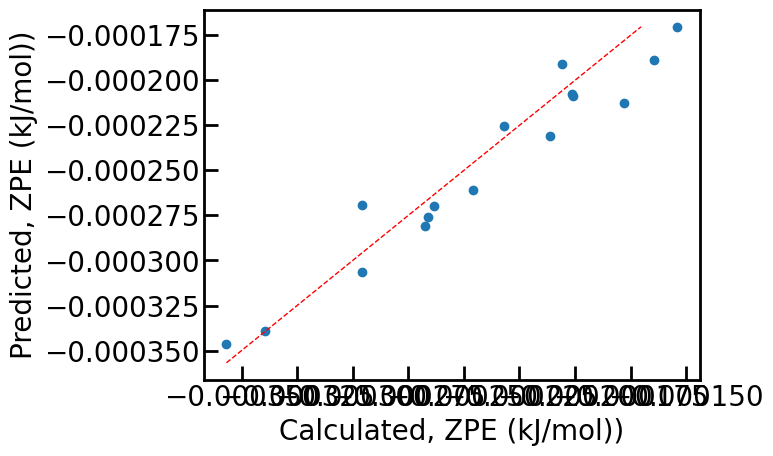

gpr3 0.9242205280835413
RMSE:  0.2847184388269324
RMSE unscaled:  1.5954115792745482e-05
----------------------------------------


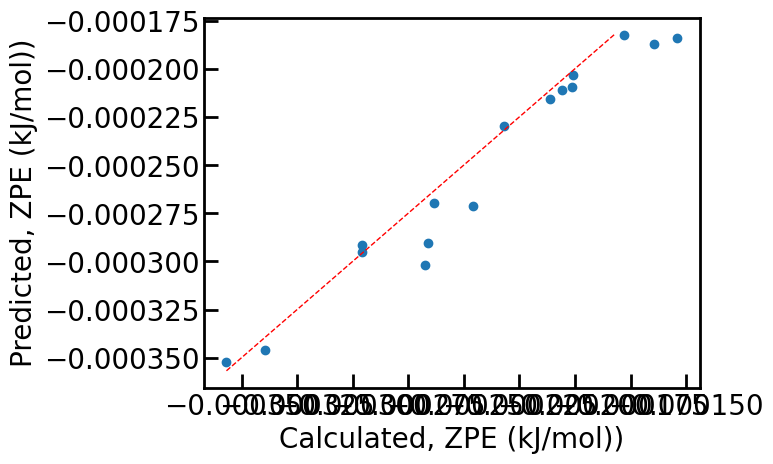

gpr4 0.9337473839291025
RMSE:  0.26622039424346283
RMSE unscaled:  1.4917583187270522e-05
----------------------------------------


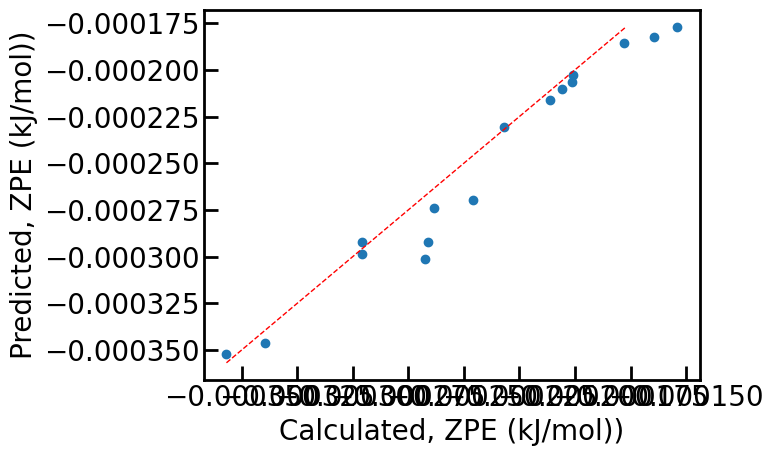

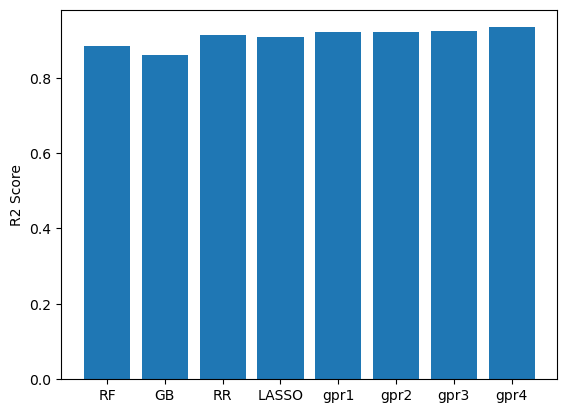

In [22]:
run_models()

In [23]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh'], dtype=object)

In [24]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8745283429447122
RMSE:  0.36636385758463313
RMSE unscaled:  2.052909333959601e-05
----------------------------------------


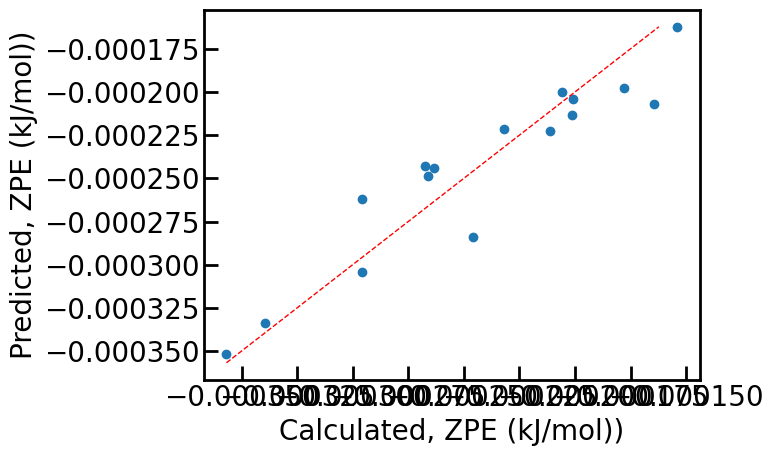

GB 0.7578174499671081
RMSE:  0.5089923209625153
RMSE unscaled:  2.852123824404061e-05
----------------------------------------


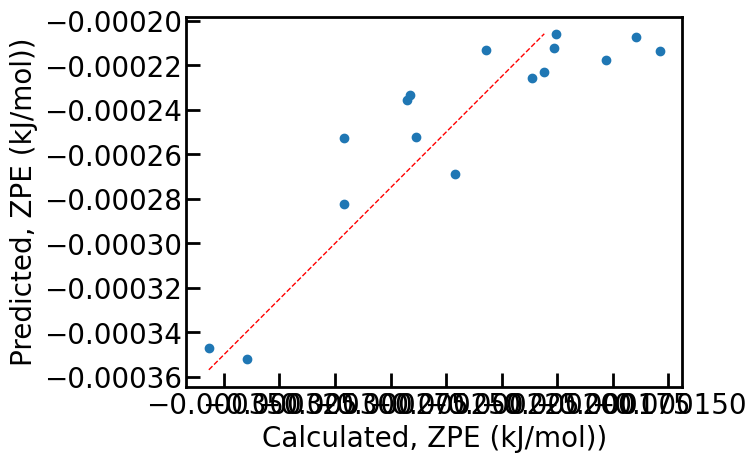

RR 0.8962151904515021
RMSE:  0.3332013119854063
RMSE unscaled:  1.867083963937159e-05
----------------------------------------


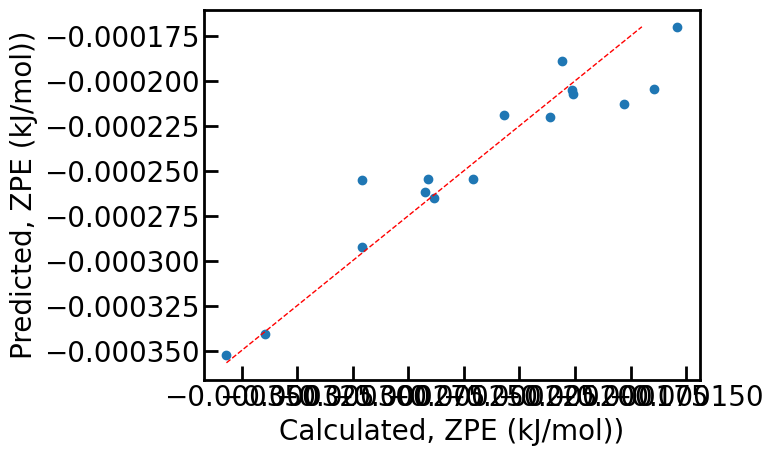

LASSO 0.8686980102565098
RMSE:  0.3747791830085008
RMSE unscaled:  2.100064367823646e-05
----------------------------------------


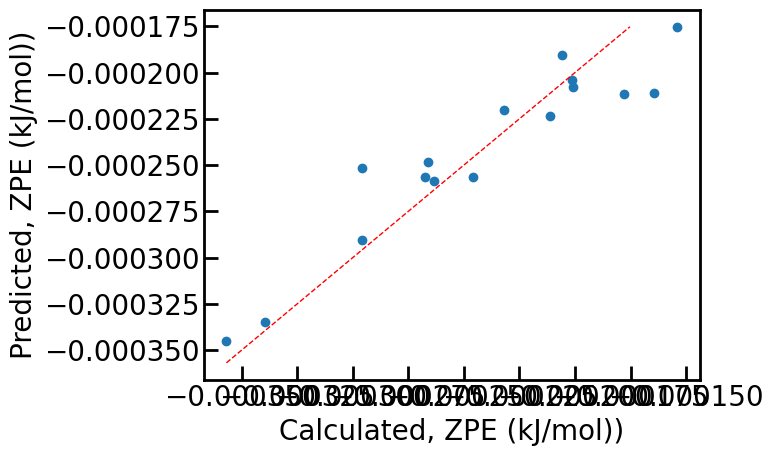

gpr1 0.8955907137437188
RMSE:  0.3342022503530353
RMSE unscaled:  1.872692693278451e-05
----------------------------------------


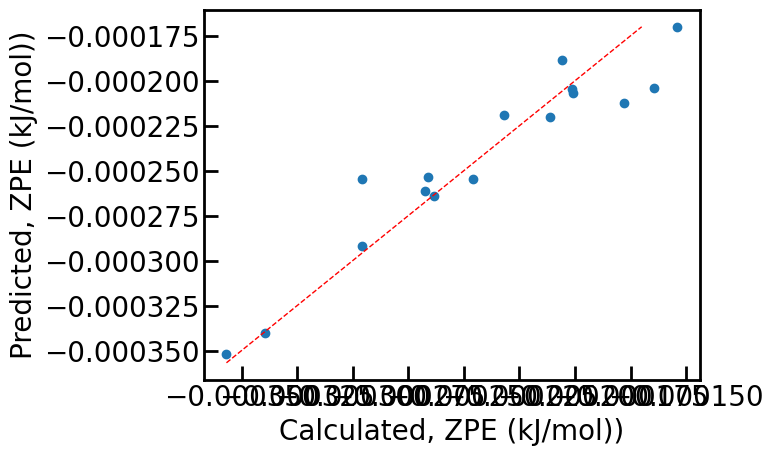

gpr2 0.9023715490671289
RMSE:  0.32316774336984716
RMSE unscaled:  1.8108611509129588e-05
----------------------------------------


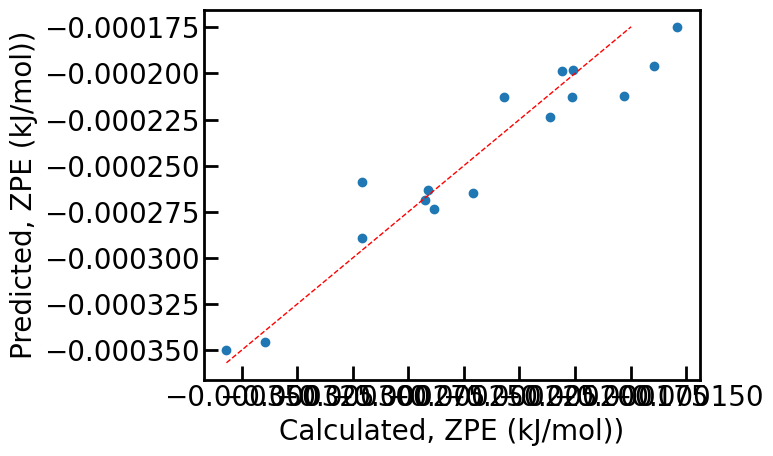

gpr3 0.9527681159600986
RMSE:  0.22477988319880093
RMSE unscaled:  1.2595476075272185e-05
----------------------------------------


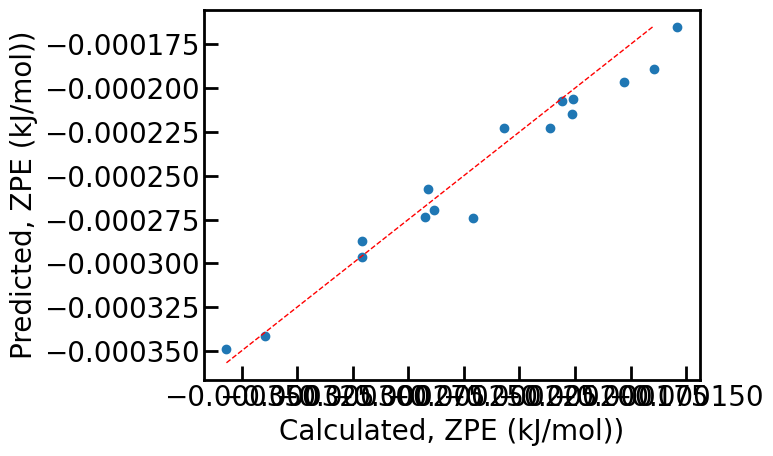

gpr4 0.9481654536715827
RMSE:  0.23547752220592125
RMSE unscaled:  1.3194915198820953e-05
----------------------------------------


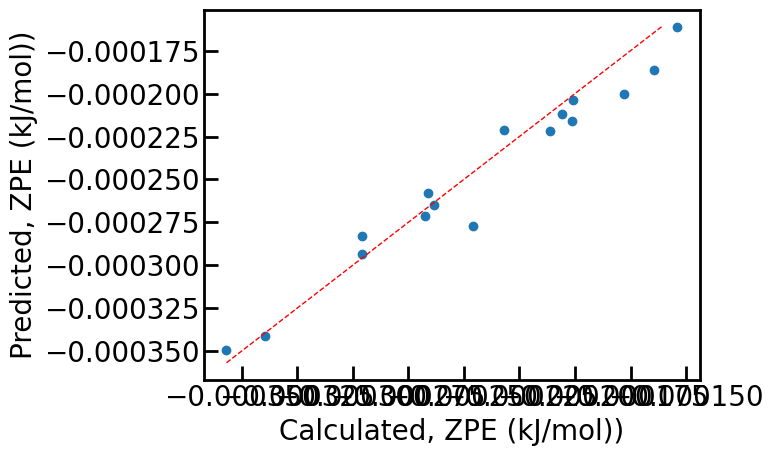

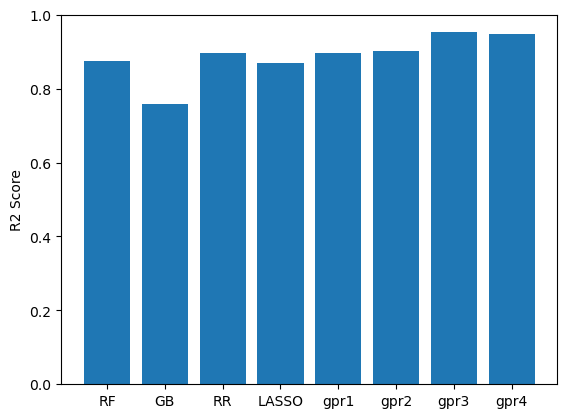

In [25]:
run_models()

# Min-Max scaling

In [26]:
df_test = pd.read_csv('scaled_minmax_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_minmax_'+target+'_train.csv', encoding='cp1252')   

In [27]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [28]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [29]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [30]:
with open("minmax_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [31]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.840991288376412
RMSE:  0.11142555273203027
RMSE unscaled:  2.3110397311198858e-05
----------------------------------------


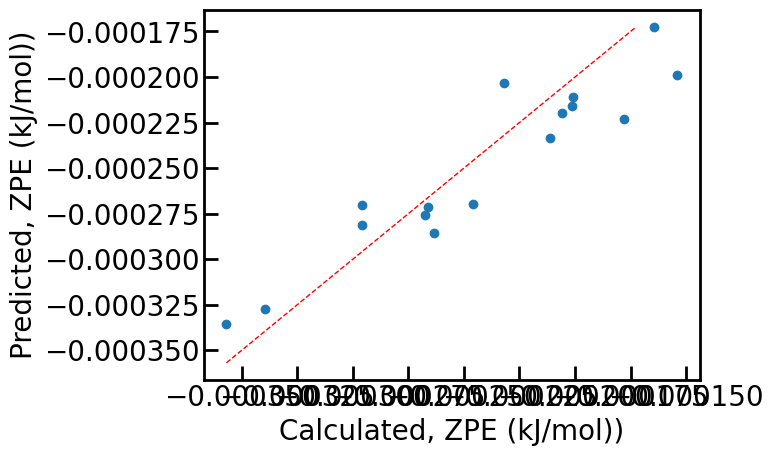

GB 0.8879467692350838
RMSE:  0.09353766604075305
RMSE unscaled:  1.940033118761131e-05
----------------------------------------


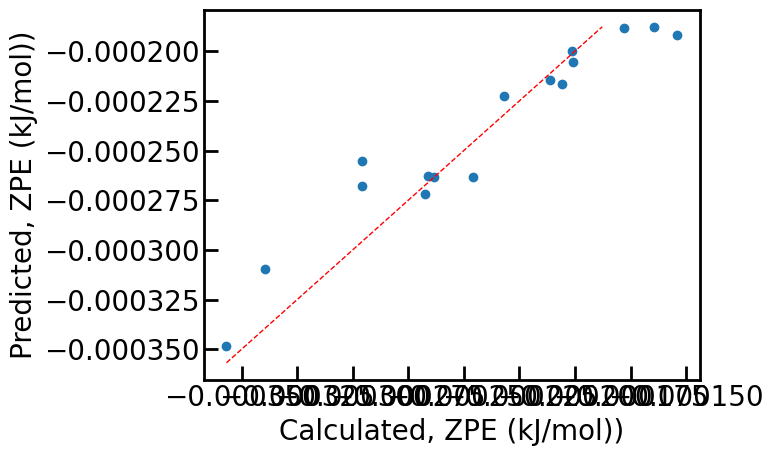

RR 0.9185619522840478
RMSE:  0.07974216355656039
RMSE unscaled:  1.653905264153078e-05
----------------------------------------


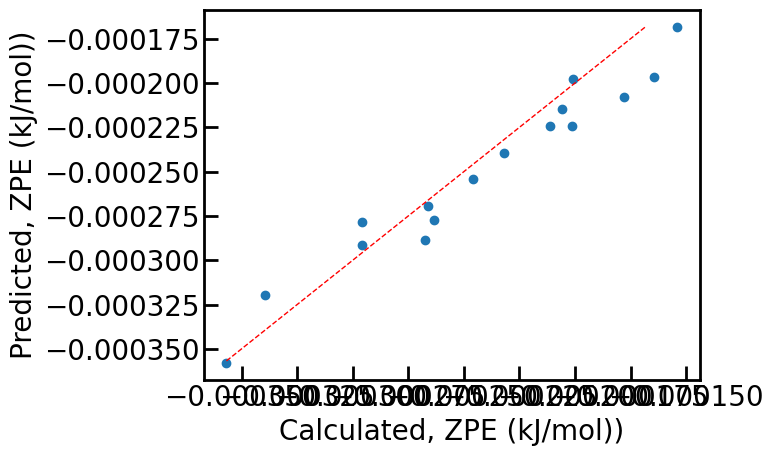

LASSO 0.674563653164447
RMSE:  0.15940699165742017
RMSE unscaled:  3.306206539756257e-05
----------------------------------------


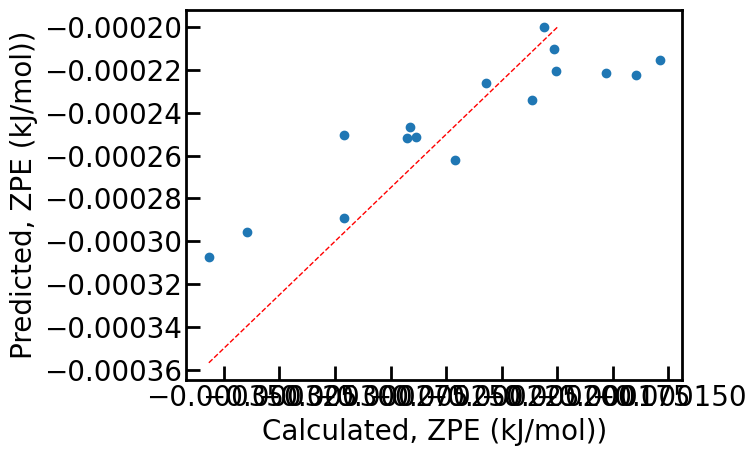

gpr1 0.9064932899843803
RMSE:  0.08544678489548292
RMSE unscaled:  1.772222887373219e-05
----------------------------------------


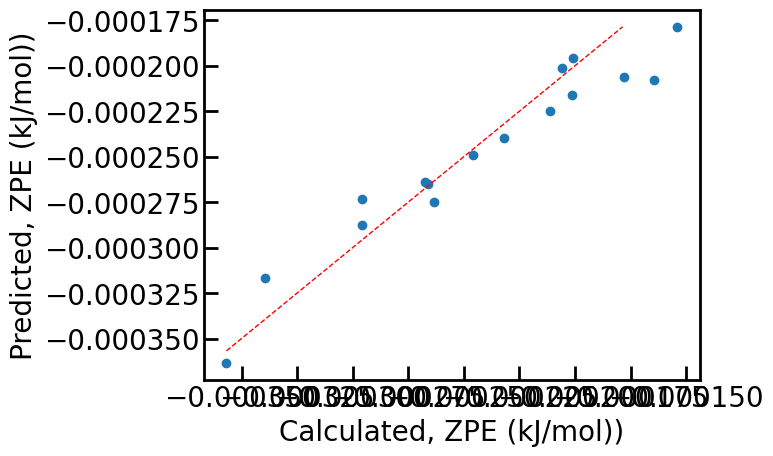

gpr2 -0.02173484934841352
RMSE:  0.28245121095577913
RMSE unscaled:  5.858225107409223e-05
----------------------------------------


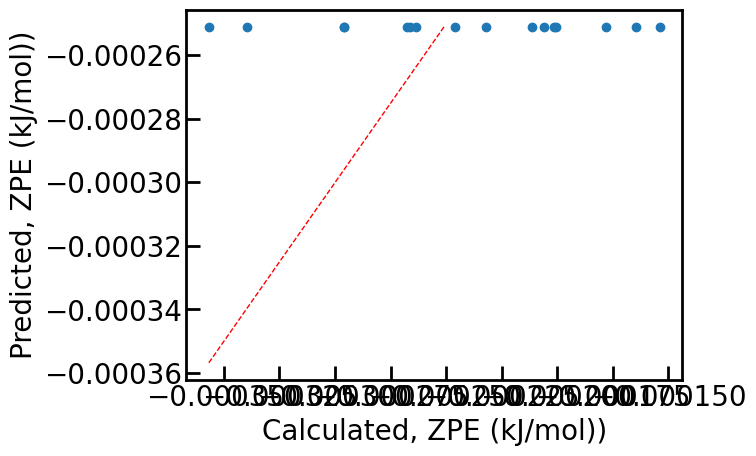

gpr3 0.974055003963514
RMSE:  0.045009184278315205
RMSE unscaled:  9.335202795236573e-06
----------------------------------------


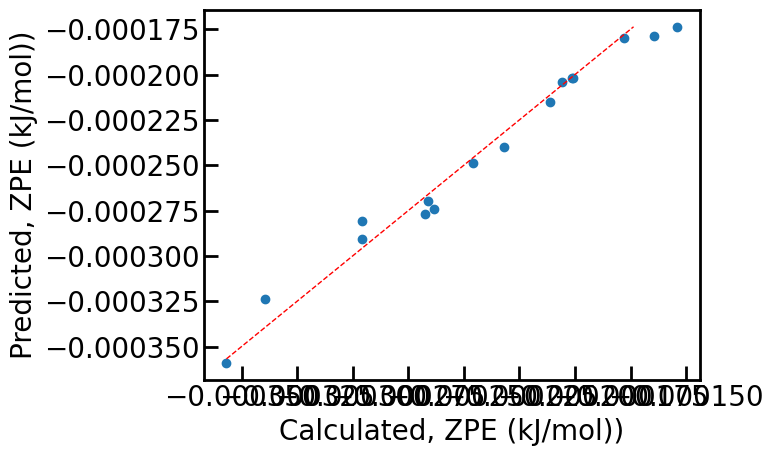

gpr4 0.9338288614883319
RMSE:  0.07188009480579544
RMSE unscaled:  1.4908407533086921e-05
----------------------------------------


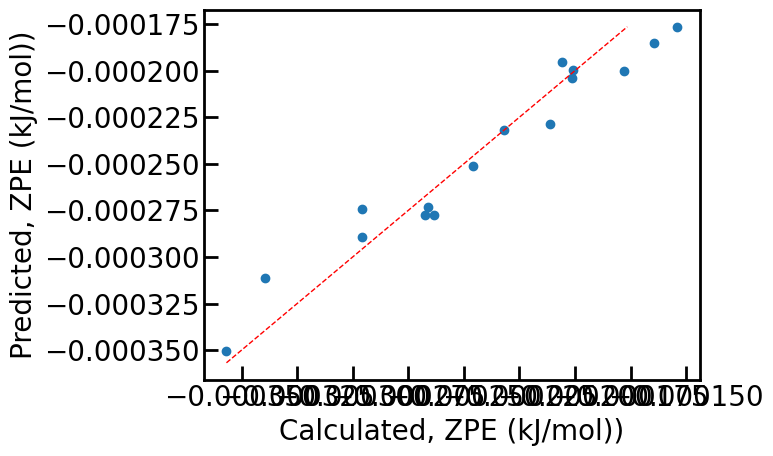

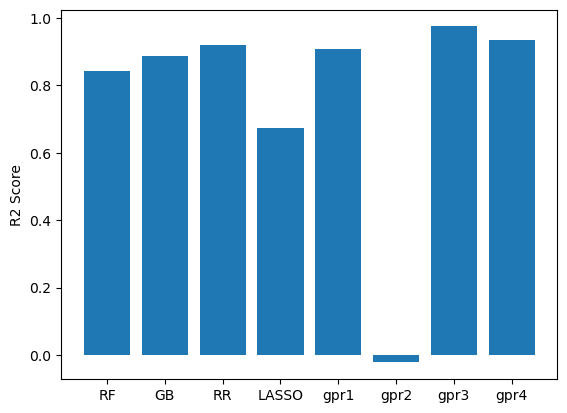

In [32]:
run_models()

## Feature selection


In [33]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
26      X_EA  107.076012
1   mean_A2B   99.929262
14       X_Z   79.740038
34    X_Rvdw   72.806569
4   mean_X2X   53.239994
32    A_Rvdw   39.367219
2   mean_A2X   37.109735
18     A_IEI   26.852117
9      E_coh   26.552367
30    A_ChiA   24.705897
23    X_IEII   16.899791
44      B_Hf   13.952951
17       X_G   13.049317
24      A_EA   12.978514
6    std_A2X   12.535370
27    A_ChiP   12.150673
38      B_MP   11.671236
41     X_Rho   11.006974
7    std_B2X   10.854134
11        OF    8.715184
37      A_MP    8.689131
13       B_Z    8.230539
47   X_Kappa    8.186239
45   A_Kappa    7.476652
46   B_Kappa    7.450582
36      B_Ra    7.059603
12       A_Z    6.801723
31    B_ChiA    5.624544
40     B_Rho    4.879926
43      X_MV    4.828899


In [34]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'X_Rho', 'std_B2X', 'OF',
       'A_MP', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra', 'A_Z',
       'B_ChiA', 'B_Rho', 'X_MV', 'A_CvM', 'A_G', 'B_EA', 'B_CvM', 'TF',
       'std_X2X', 'A_B', 'std_A2B', 'B_ChiP', 'X_IEI'], dtype=object)

In [35]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8928756981625642
RMSE:  0.091457292419455
RMSE unscaled:  1.8968847925782138e-05
----------------------------------------


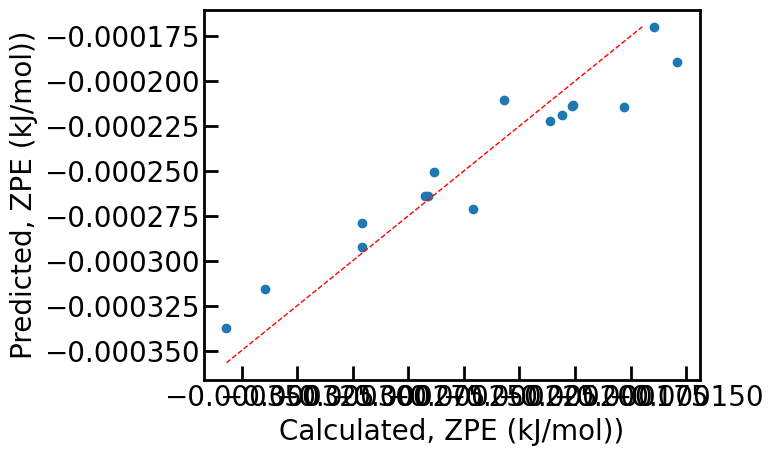

GB 0.90482082429534
RMSE:  0.08620755092994409
RMSE unscaled:  1.7880016785806054e-05
----------------------------------------


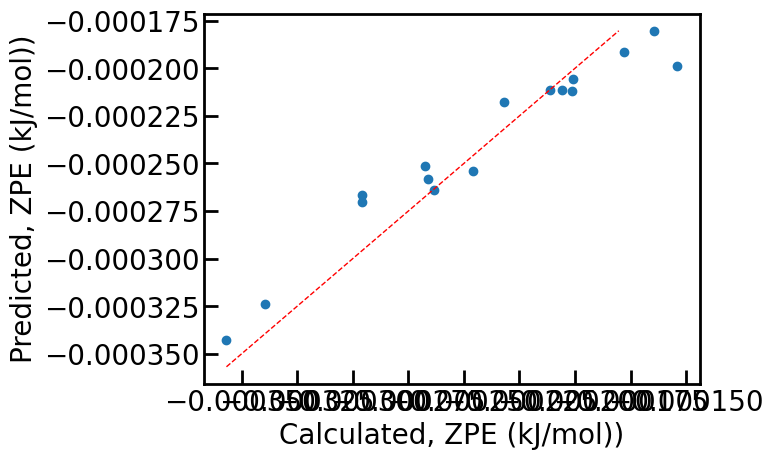

RR 0.9248108443623746
RMSE:  0.07662172791735421
RMSE unscaled:  1.5891853631627655e-05
----------------------------------------


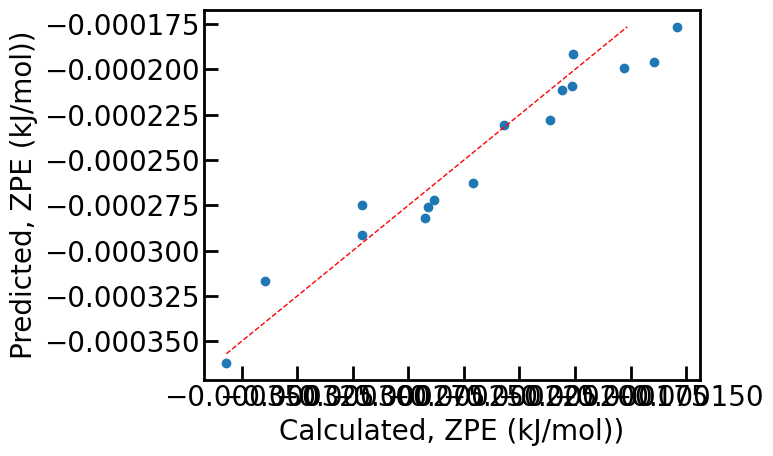

LASSO 0.6745632922466687
RMSE:  0.1594070800507448
RMSE unscaled:  3.3062083730923314e-05
----------------------------------------


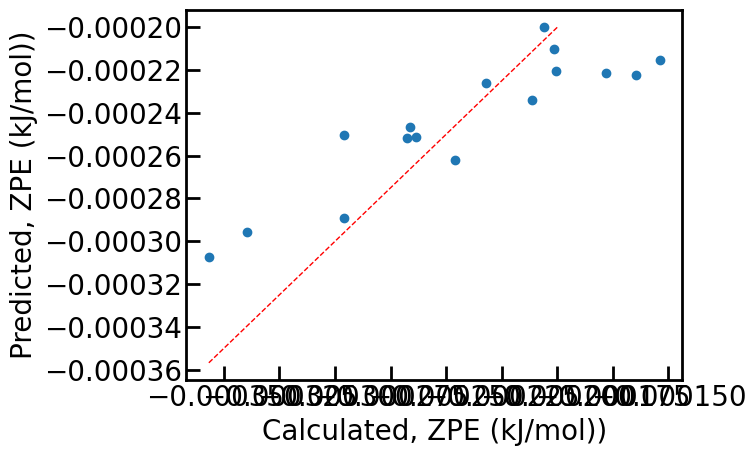

gpr1 0.8775725104766993
RMSE:  0.09777184481122386
RMSE unscaled:  2.0278527896292256e-05
----------------------------------------


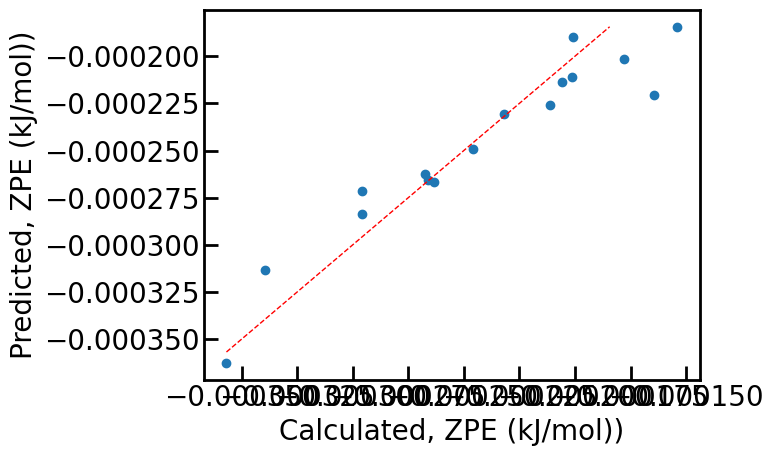

gpr2 -0.021734563907494397
RMSE:  0.2824511715017374
RMSE unscaled:  5.858224289106276e-05
----------------------------------------


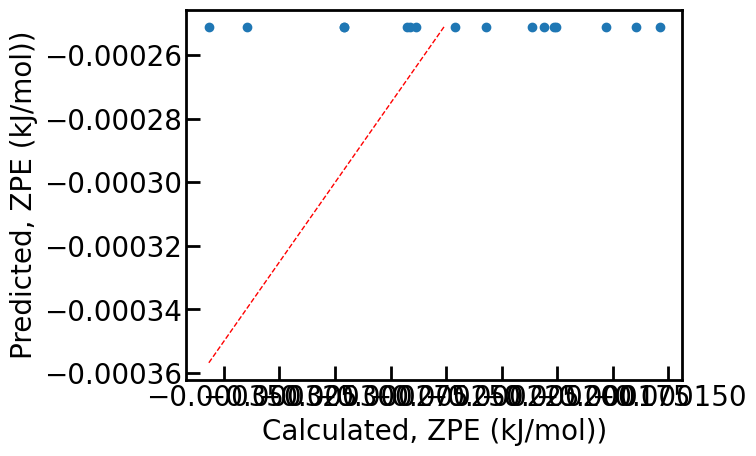

gpr3 0.9554961220846645
RMSE:  0.05894856881626328
RMSE unscaled:  1.2226323431813496e-05
----------------------------------------


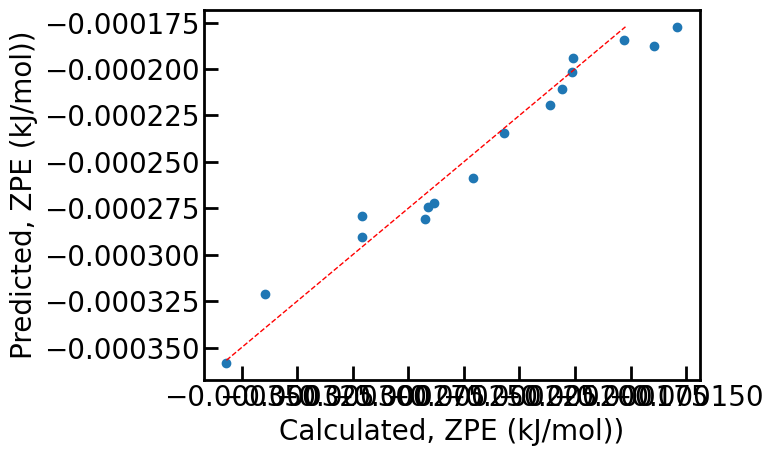

gpr4 0.9332199985292535
RMSE:  0.07221003406862272
RMSE unscaled:  1.4976839120506019e-05
----------------------------------------


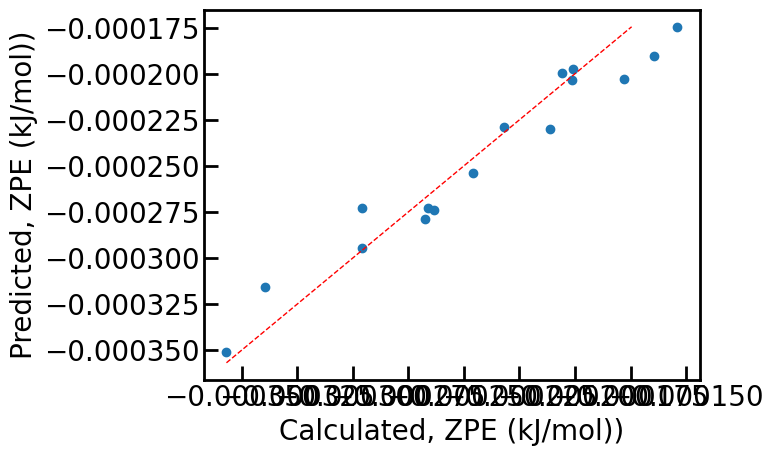

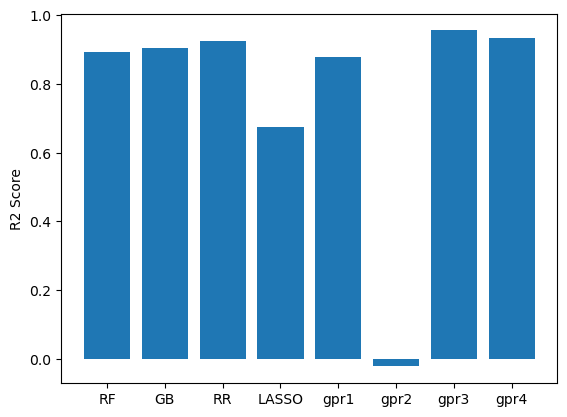

In [36]:
run_models()

In [37]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'X_Rho', 'std_B2X', 'OF',
       'A_MP', 'B_Z', 'X_Kappa', 'A_Kappa', 'B_Kappa', 'B_Ra', 'A_Z',
       'B_ChiA', 'B_Rho', 'X_MV'], dtype=object)

In [38]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.920716518301791
RMSE:  0.07868024337637265
RMSE unscaled:  1.6318803365891655e-05
----------------------------------------


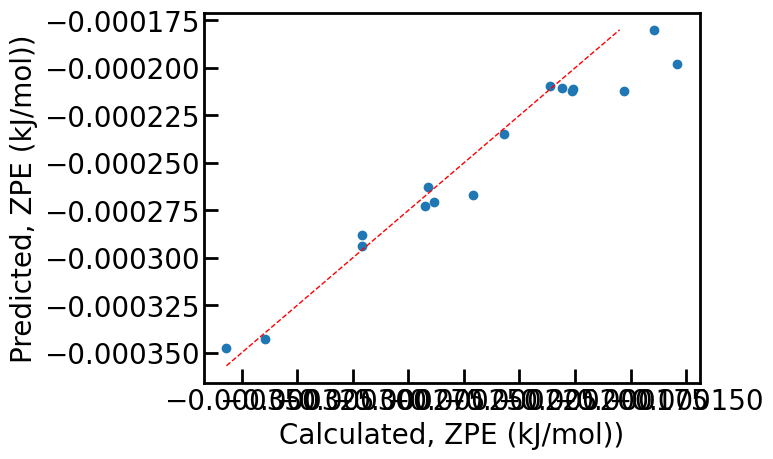

GB 0.8687507367079526
RMSE:  0.10123315565182937
RMSE unscaled:  2.0996426679673917e-05
----------------------------------------


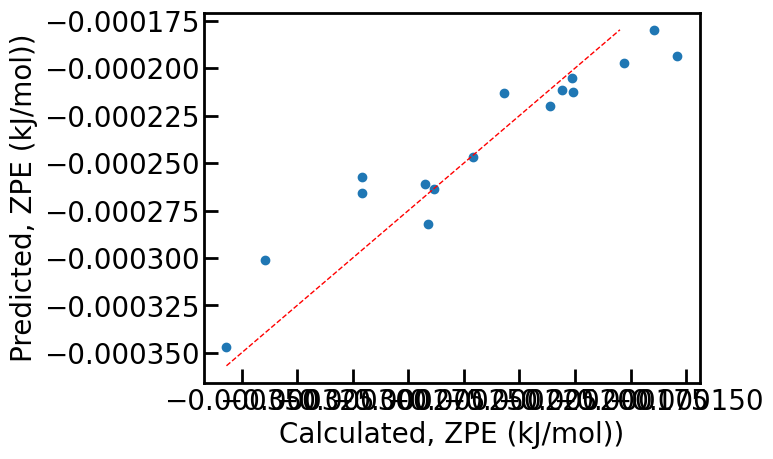

RR 0.9238484251322364
RMSE:  0.07711054673300444
RMSE unscaled:  1.599323789013821e-05
----------------------------------------


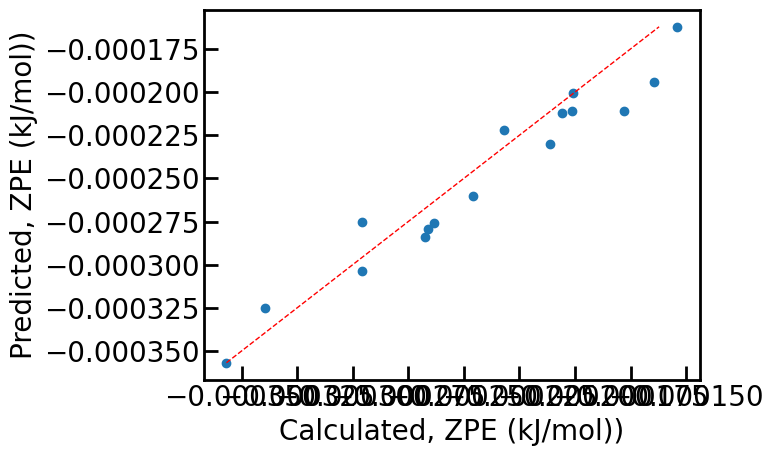

LASSO 0.6745632922466687
RMSE:  0.1594070800507448
RMSE unscaled:  3.3062083730923314e-05
----------------------------------------


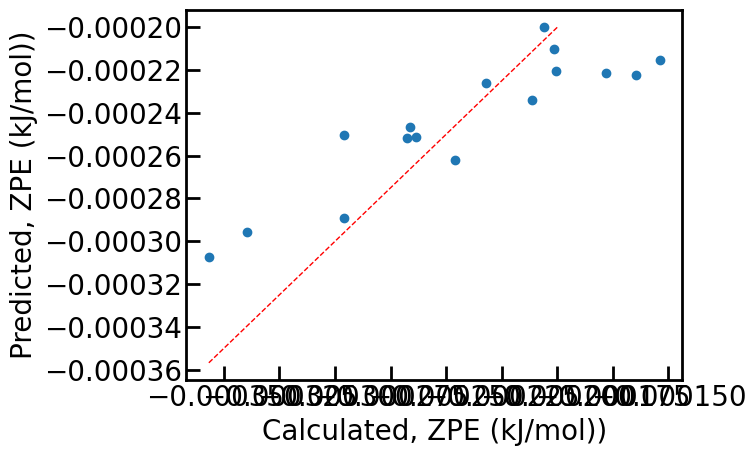

gpr1 0.8933158615781797
RMSE:  0.09126920441859594
RMSE unscaled:  1.8929837229198246e-05
----------------------------------------


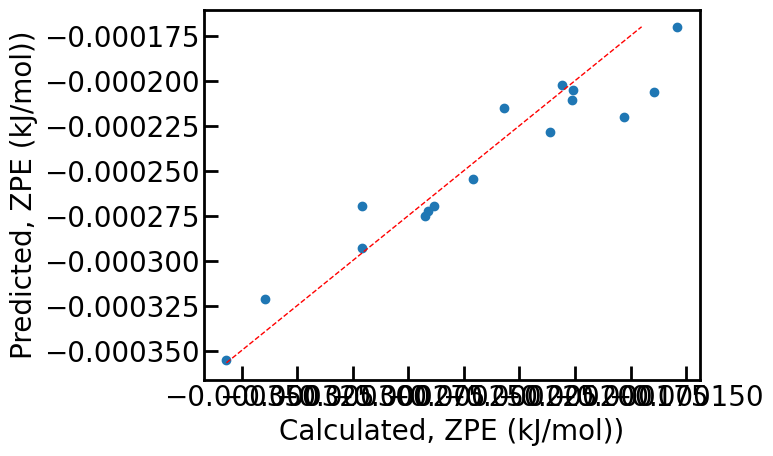

gpr2 -0.02173479231166775
RMSE:  0.28245120307208105
RMSE unscaled:  5.8582249438961066e-05
----------------------------------------


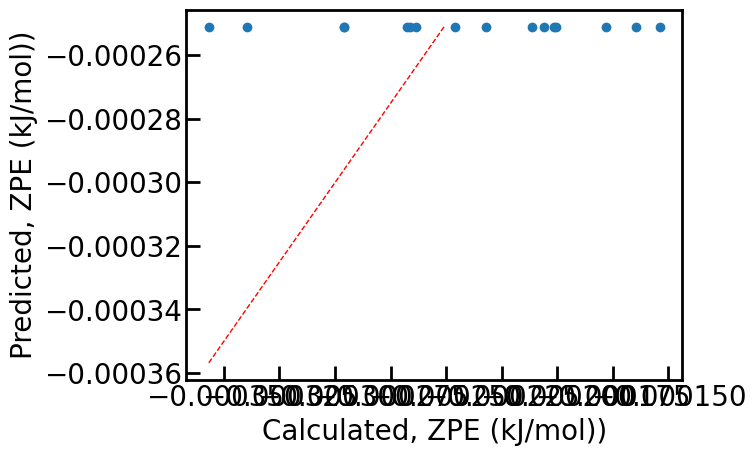

gpr3 0.9533161497482243
RMSE:  0.06037507335221494
RMSE unscaled:  1.252218991650892e-05
----------------------------------------


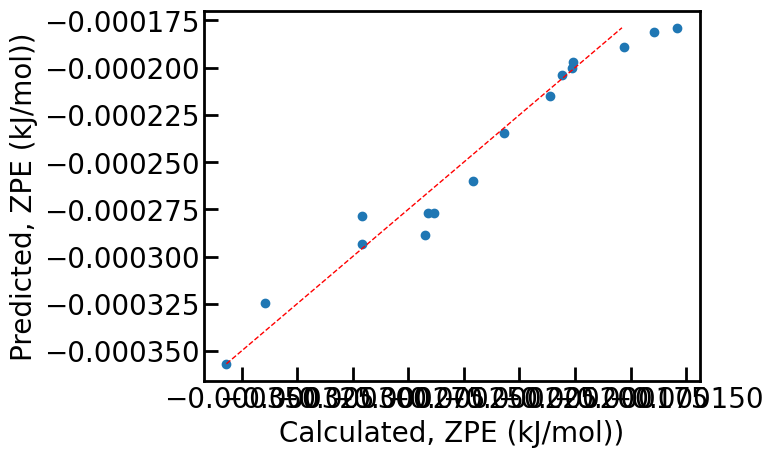

gpr4 0.9332215039857985
RMSE:  0.07220922012972868
RMSE unscaled:  1.4976670304190842e-05
----------------------------------------


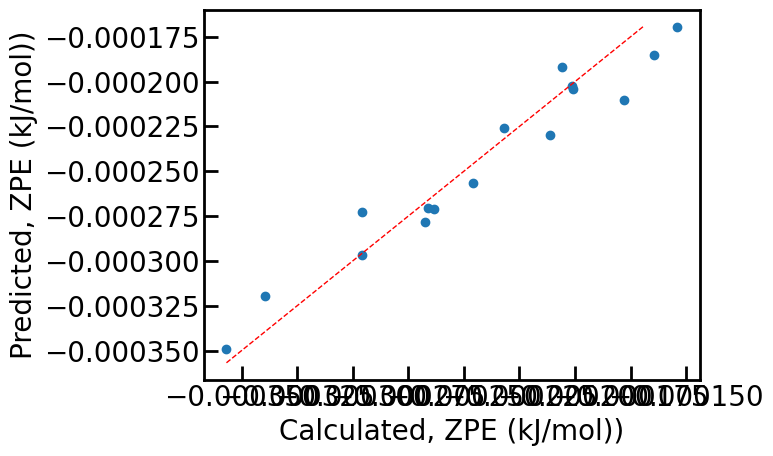

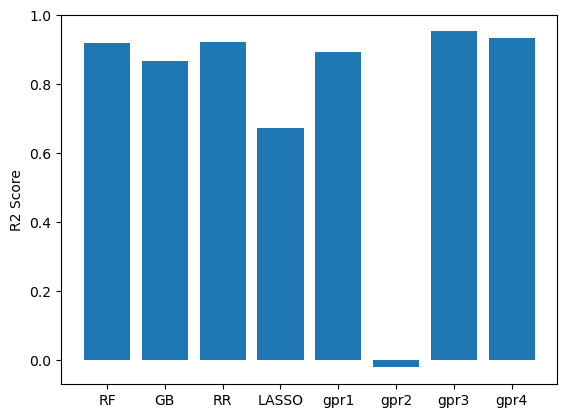

In [39]:
run_models()

In [40]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf', 'X_G',
       'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'X_Rho', 'std_B2X', 'OF'],
      dtype=object)

In [41]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9116332334614672
RMSE:  0.08306514350043191
RMSE unscaled:  1.7228260681132823e-05
----------------------------------------


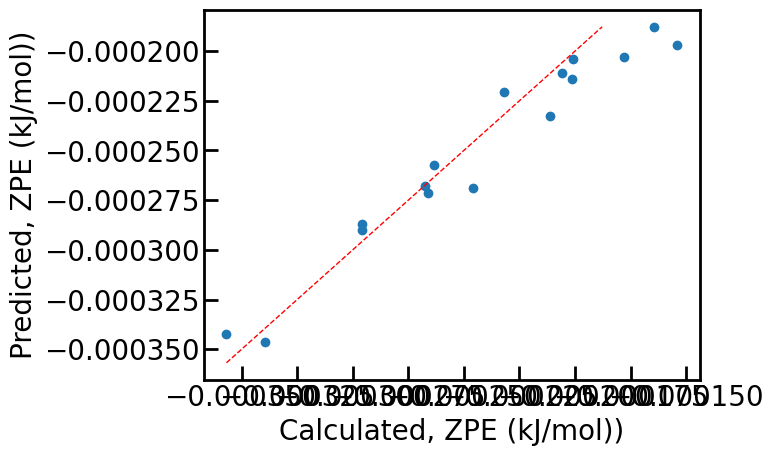

GB 0.8800454686930033
RMSE:  0.09677934240434044
RMSE unscaled:  2.0072676326405426e-05
----------------------------------------


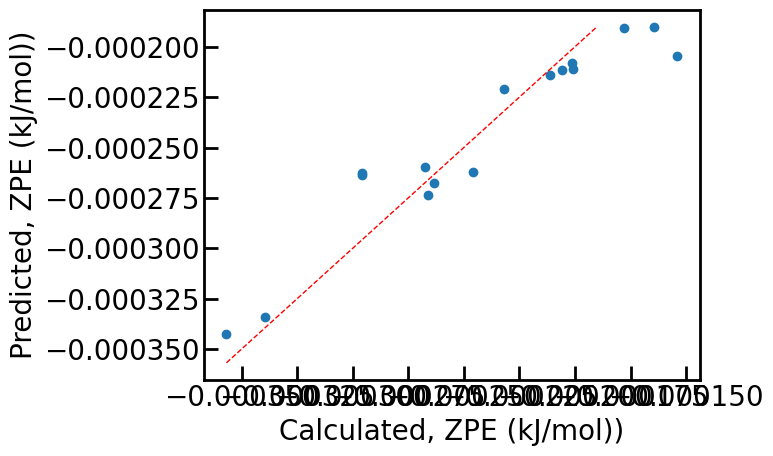

RR 0.9140249816367884
RMSE:  0.08193330551548123
RMSE unscaled:  1.6993509989906518e-05
----------------------------------------


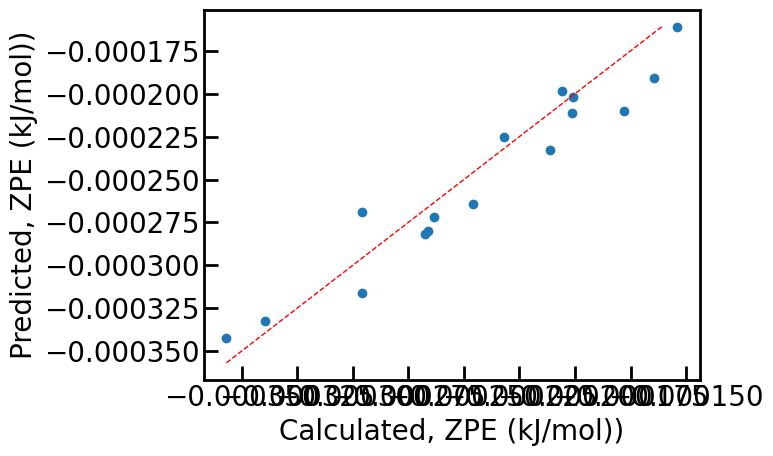

LASSO 0.6579646297306245
RMSE:  0.16342174644841484
RMSE unscaled:  3.389475212023974e-05
----------------------------------------


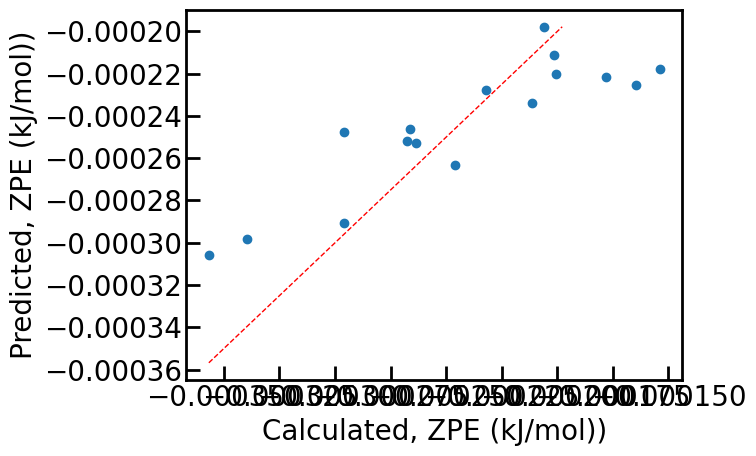

gpr1 0.9084693229683765
RMSE:  0.08453911072439022
RMSE unscaled:  1.7533971241539752e-05
----------------------------------------


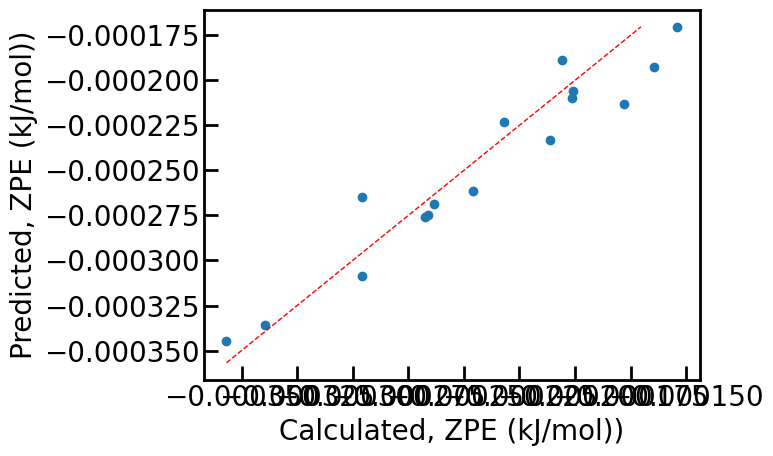

gpr2 -0.021734827458370187
RMSE:  0.28245120793010703
RMSE unscaled:  5.85822504465478e-05
----------------------------------------


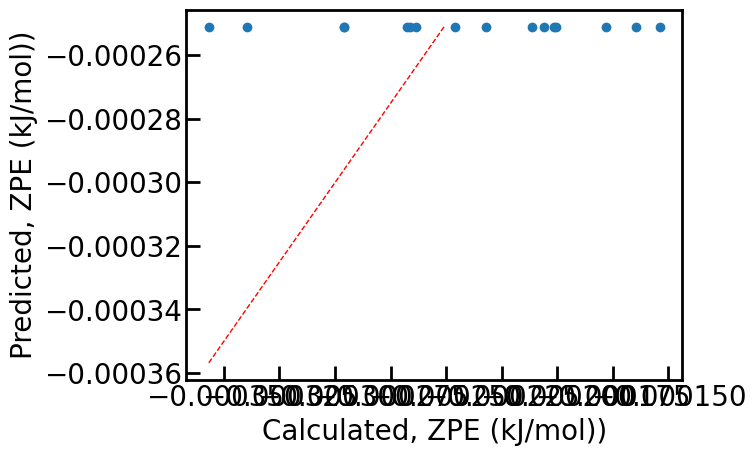

gpr3 0.9395407625065374
RMSE:  0.06870774110720461
RMSE unscaled:  1.4250440373952421e-05
----------------------------------------


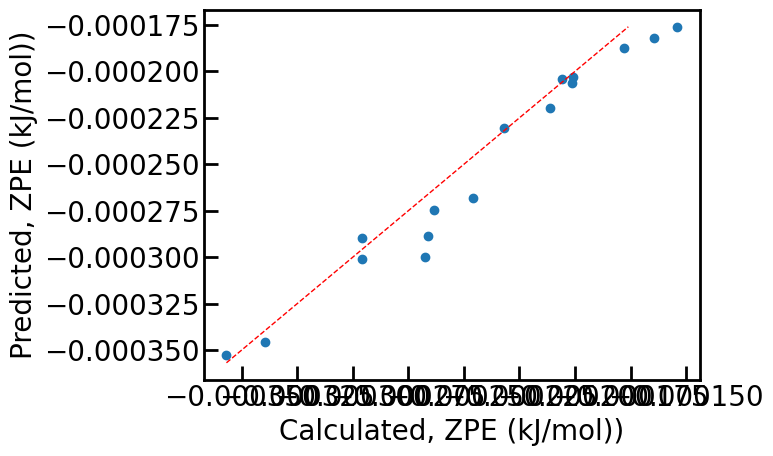

gpr4 0.9132944501423057
RMSE:  0.082280663687676
RMSE unscaled:  1.7065554374447457e-05
----------------------------------------


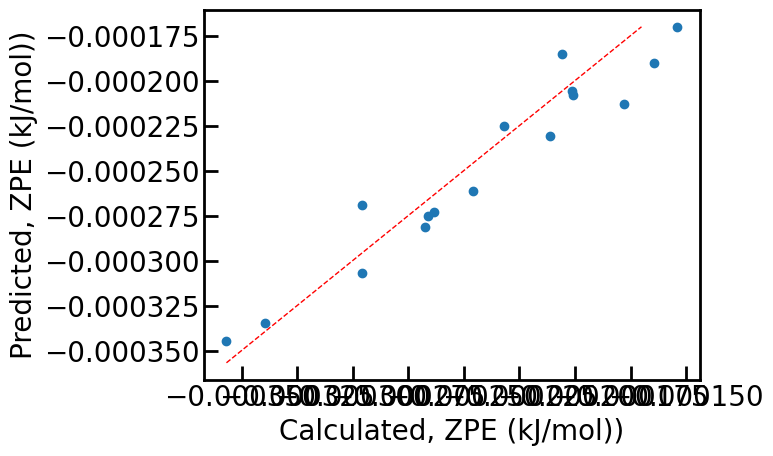

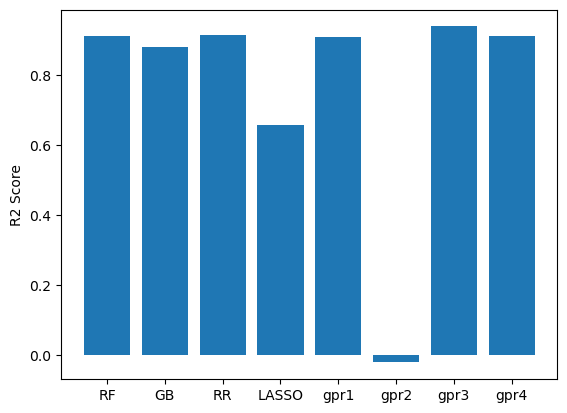

In [42]:
run_models()

In [43]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'mean_A2B', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA'], dtype=object)

In [44]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8629690936737555
RMSE:  0.10343883077597596
RMSE unscaled:  2.1453898302731892e-05
----------------------------------------


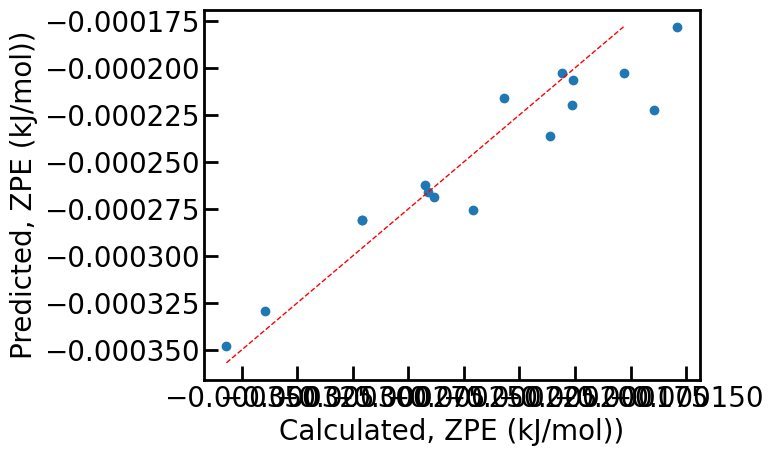

GB 0.8236204009044648
RMSE:  0.1173541665205733
RMSE unscaled:  2.4340031060356785e-05
----------------------------------------


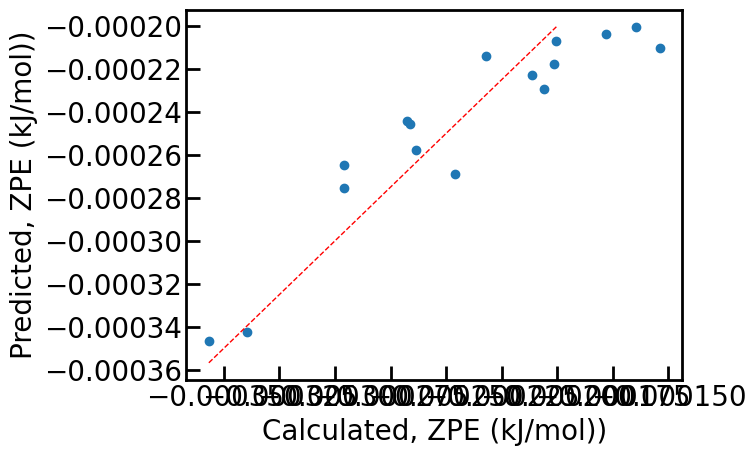

RR 0.8809316468439792
RMSE:  0.0964211953506608
RMSE unscaled:  1.9998394256418505e-05
----------------------------------------


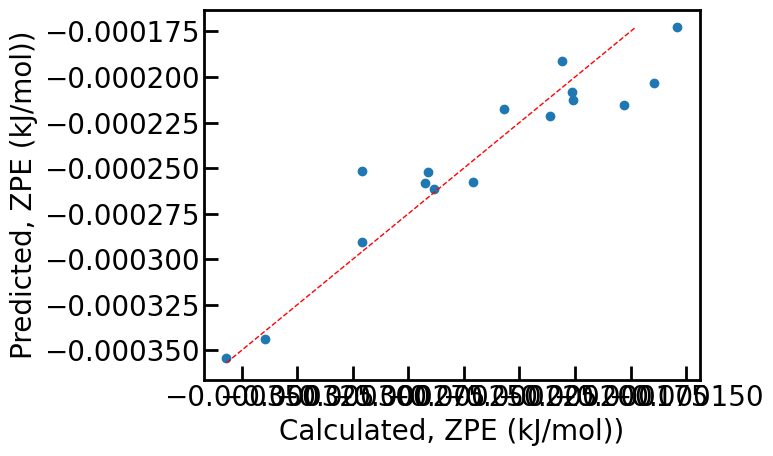

LASSO 0.6579646297306245
RMSE:  0.1634217464484148
RMSE unscaled:  3.389475212023973e-05
----------------------------------------


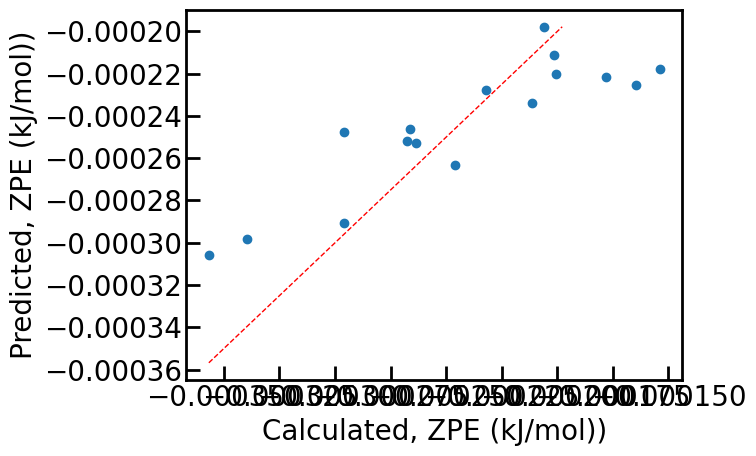

gpr1 0.8625805369882598
RMSE:  0.10358537946062432
RMSE unscaled:  2.1484293470129474e-05
----------------------------------------


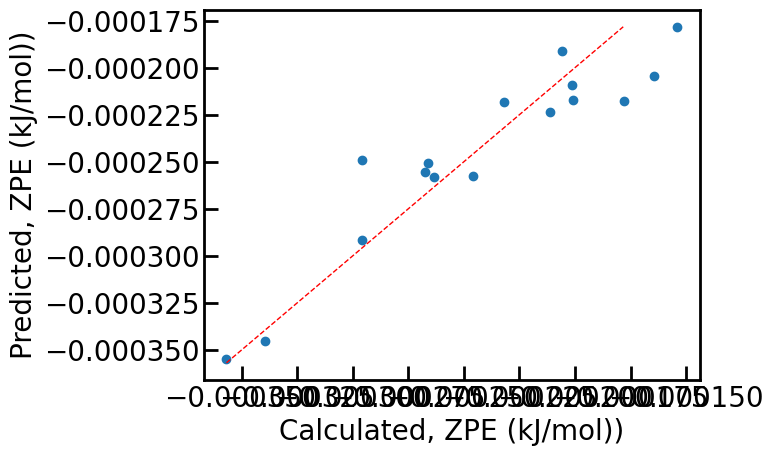

gpr2 -0.02173479644460241
RMSE:  0.28245120364334103
RMSE unscaled:  5.8582249557444163e-05
----------------------------------------


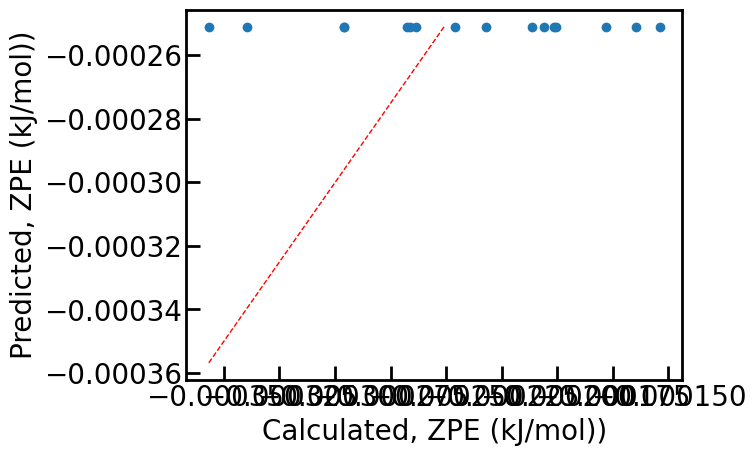

gpr3 0.9352555927151436
RMSE:  0.07110096046925977
RMSE unscaled:  1.4746809913558478e-05
----------------------------------------


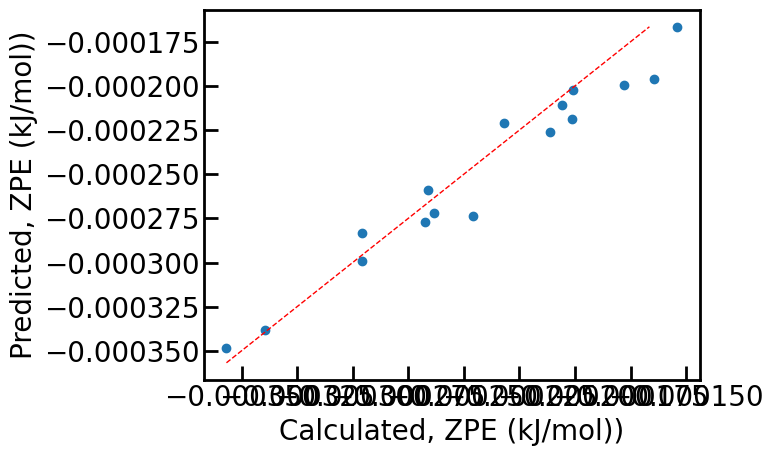

gpr4 0.8816380273791105
RMSE:  0.09613475747138912
RMSE unscaled:  1.993898514394261e-05
----------------------------------------


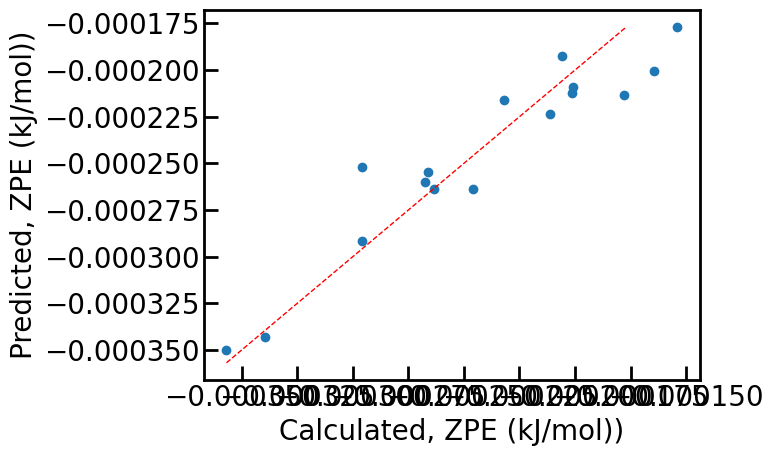

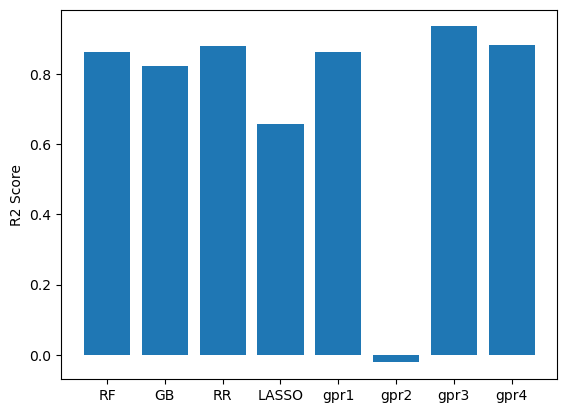

In [45]:
run_models()